# Initial Staging

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=1690673d18812659816a051665ba7fc7223ae0a1370a4a0aba5479e1da31108e
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [2]:
#update local version of the package catalog
!apt-get update
#pip install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 https://cli.github.com/packages stable InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,577 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,690 kB]
Ge

# Pyspark Staging

In [3]:
# download spark 3.5.6 please use ctrl+z to stop the wget when you see it is processing to long
!wget -q https://dlcdn.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz

In [4]:
# unzip it
!tar xf spark-3.5.6-bin-hadoop3.tgz


In [5]:
# install findspark
!pip install -q findspark
!pip install pyspark


In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.6-bin-hadoop3"

import findspark
findspark.init()

## Starting Pyspark

In [7]:
from pyspark.sql import SparkSession

print("Attempting to stop existing Spark session...")
try:
    spark.stop()
    print("Existing Spark session stopped.")
except Exception as e:
    print("No active Spark session to stop.")

print("Attempting to get or create Spark session...")
spark = SparkSession.builder.master("local[2]").config("spark.driver.memory", "4g").getOrCreate()
print("Spark session created.")

sc = spark.sparkContext
print("SparkContext successfully created.")

# Add your code here
# ...

# Stop the Spark session
#spark.stop()
#print("Spark session stopped.")

Attempting to stop existing Spark session...
No active Spark session to stop.
Attempting to get or create Spark session...
Spark session created.
SparkContext successfully created.


# Project Data Acquisition

In [8]:
import zipfile

# Download the zip file
zip_file_url = 'https://github.com/tulip-lab/sit742/raw/develop/Jupyter/data/business_review_submission.zip'
zip_file_name = 'business_review_submission.zip'
!wget -q {zip_file_url} -O {zip_file_name}

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('business_review_data')

# Examine the file structure
print("File structure after unzipping:")
!ls business_review_data


File structure after unzipping:
meta-review-business.csv  review.csv


## Imports

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

#pyspark imports
from pyspark.sql.functions import col, from_unixtime, date_format, col, count,when,hour, dayofweek, avg, split, explode, lower, regexp_replace, year, collect_list
from pyspark.sql.functions import countDistinct,month, dayofmonth
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StopWordsRemover





## Review Data

In [10]:
# Read the review.csv file without inferring schema initially
review_df_raw = spark.read.csv('business_review_data/review.csv', header=True)

# Displaying the first few rows and the schema of the raw DataFrame
review_df_raw.show(5)
review_df_raw.printSchema()

+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+
|             user_id|                name|         time|              rating|                text|pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Allen Ratliff|1504917982385|                   5|Great campground ...|NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|   Jonathan Tringali|1474765901185|                   4|We tent camped he...|NULL|NULL|                NULL|
|There is a bath h...| 2 restrooms (sin...|       toilet| shower). The hot...| but they lack ve...|NULL|NULL|                NULL|
|Wi-Fi didn't reac...|                NULL|         NULL|0x56b646ed2220b77...|     

In [11]:
# Show the number of rows in the review_df_raw DataFrame
row_count = review_df_raw.count()
print(f"Number of rows in review_df_raw: {row_count}")

# Show the number of columns in the review_df DataFrame
col_count = len(review_df_raw.columns)
print(f"Number of columns in review_df_raw: {col_count}")

Number of rows in review_df_raw: 552624
Number of columns in review_df_raw: 8


## Meta data of Review Business

In [12]:
# Read the meta-review-business.csv file into a Spark DataFrame
meta_review_business_df = spark.read.csv('business_review_data/meta-review-business.csv', header=True, inferSchema=True)

# Display the first few rows of the DataFrame
meta_review_business_df.show(5)

+--------------------+--------------------+--------------------+-----------+------------------+-------------------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                name|             address|             gmap_id|description|          latitude|          longitude|            category|avg_rating|num_of_reviews|price|               hours|                MISC|               state|    relative_results|                 url|
+--------------------+--------------------+--------------------+-----------+------------------+-------------------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|Bear Creek Cabins...|Bear Creek Cabins...|0x56b646ed2220b77...|       NULL|        61.1006437|-146.21455179999998|['RV park', 'Cabi...|       4.5|            18| NULL|          

In [13]:
# Show the number of rows in the review_df DataFrame
row_count = meta_review_business_df.count()
print(f"Number of rows in meta_review_business_df: {row_count}")

# Show the number of columns in the review_df DataFrame
col_count = len(meta_review_business_df.columns)
print(f"Number of columns in meta_review_business_df: {col_count}")

Number of rows in meta_review_business_df: 12774
Number of columns in meta_review_business_df: 15


# Part I

## Answer 1.1


### 1.1.1

In [14]:


# Replace null or None in 'text' column with 'no review'
review_df = review_df_raw.withColumn('text', when(col('text').isNull(), 'no review').otherwise(col('text')))

# Display the schema and some rows to verify the change
review_df.show(5)
review_df.printSchema()

+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+
|             user_id|                name|         time|              rating|                text|pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Allen Ratliff|1504917982385|                   5|Great campground ...|NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|   Jonathan Tringali|1474765901185|                   4|We tent camped he...|NULL|NULL|                NULL|
|There is a bath h...| 2 restrooms (sin...|       toilet| shower). The hot...| but they lack ve...|NULL|NULL|                NULL|
|Wi-Fi didn't reac...|                NULL|         NULL|0x56b646ed2220b77...|     

### 1.1.2

In [15]:
# Convert 'time' to timestamp and format as yyyy-mm-dd in a new column 'newtime'
# The 'time' column seems to be in milliseconds since the epoch, so divide by 1000
review_df = review_df.withColumn('newtime', date_format(from_unixtime(col('time') / 1000), 'yyyy-MM-dd'))

# Display the first 5 rows with the new column
review_df.show(5)

+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+----------+
|             user_id|                name|         time|              rating|                text|pics|resp|             gmap_id|   newtime|
+--------------------+--------------------+-------------+--------------------+--------------------+----+----+--------------------+----------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|NULL|NULL|0x56b646ed2220b77...|2019-08-20|
|1.132409264057589...|       Allen Ratliff|1504917982385|                   5|Great campground ...|NULL|NULL|0x56b646ed2220b77...|2017-09-09|
|1.130448378911412...|   Jonathan Tringali|1474765901185|                   4|We tent camped he...|NULL|NULL|                NULL|2016-09-25|
|There is a bath h...| 2 restrooms (sin...|       toilet| shower). The hot...| but they lack ve...|NULL|NULL|                NULL|      NULL|
|Wi-Fi

**Insight**

*   There are 8 columns in the review dataframe originally
*   The time is stored as unix timestamp
*   Some columns like ratings and time have inappropriate entries
*   Creation of new column to store time in date format successfully done


## Answer 1.2

###1.2.1


In [16]:


# Calculate the number of reviews per unique gmap_id
review_counts = review_df.groupBy('gmap_id').agg(count('user_id').alias('review_count'))

# Cast the review_count column to float
review_counts = review_counts.withColumn('review_count', col('review_count').cast('float')).orderBy('review_count', ascending=False)

# Show the top 5 rows
review_counts.show(5)

+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|                NULL|     46307.0|
|0x56c897b9ce6000d...|      2737.0|
|0x56c899d05892048...|      2555.0|
|0x56c897c63697ee3...|      2220.0|
|0x56c8965ee2fb87a...|      2202.0|
+--------------------+------------+
only showing top 5 rows





*   Top Reviews count have no gmap_id. This can make the reviews difficult to use for some operation downs the line




### 1.2.2

In [17]:

# Convert the PySpark DataFrame to a Pandas DataFrame
# First, filter out rows where 'time' is not a valid number
review_df_filtered_time = review_df.filter(col('time').cast('float').isNotNull())

df = review_df_filtered_time.toPandas()

# Create the 'review_time' column with hourly information using the original 'time' column (Unix timestamp in milliseconds)
# Convert milliseconds to seconds by dividing by 1000, then convert to datetime and extract the hour
df['review_time'] = pd.to_datetime(df['time'].astype(float) / 1000, unit='s').dt.hour

# Print the first 5 rows of the pandas DataFrame with the new 'review_time' column
print("Pandas DataFrame with 'review_time' column (first 5 rows):")
display(df.head())

Pandas DataFrame with 'review_time' column (first 5 rows):


user_id               name           time rating  \
0   1.091298048426862e+20         Nicki Gore  1566331951619      5   
1  1.1324092640575896e+20      Allen Ratliff  1504917982385      5   
2  1.1304483789114126e+20  Jonathan Tringali  1474765901185      4   
3  1.1032915514759202e+20             S Blad  1472858535682      4   
4    1.08989634908602e+20     Daniel Formoso  1529649811341      5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id     newtime  review_time  
0  0x56b646ed2220b77f:0xd8975e316de80952  2019-08-20           20  
1  0x56b646ed2220b77f:0xd8975e316de80952  2017-09-09            0  
2                                   None  2016-09-25            1  
3  0x56b646ed2220b77f:0xd8975e316de80952  2016-09-02           23  
4  0x56b646ed2220b77f:0xd8975e316de80952  2018-06-22            6



*   New column called review_time which shows the hour of the day review was carried out was created successfully




### 1.2.3

In [18]:
import numpy as np
import pandas as pd

# Assuming 'review_time' is a string column like '01', '14', etc.
df['review_time'] = pd.to_numeric(df['review_time'])

# Define conditions and choices. This is customizable to preference
conditions = [
    (df['review_time'] >= 0) & (df['review_time'] < 6),
    (df['review_time'] >= 6) & (df['review_time'] < 12),
    (df['review_time'] >= 12) & (df['review_time'] < 18)
]
choices = ['0-6am', '6am-12pm', '12pm-6pm']

# Use np.select to create the new column
df['period_of_day'] = np.select(conditions, choices, default='6pm-12am')

display(df.head())

user_id               name           time rating  \
0   1.091298048426862e+20         Nicki Gore  1566331951619      5   
1  1.1324092640575896e+20      Allen Ratliff  1504917982385      5   
2  1.1304483789114126e+20  Jonathan Tringali  1474765901185      4   
3  1.1032915514759202e+20             S Blad  1472858535682      4   
4    1.08989634908602e+20     Daniel Formoso  1529649811341      5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id     newtime  review_time  \
0  0x56b646ed2220b77f:0xd8975e316de80952  2019-08-20           20   
1  0x56b646ed2220b77f:0xd8975e316de80952  2017-09-09            0   
2                                   None  2016-09-25            1   
3  0x56b646ed2220b77f:0xd8975e316de80952  2016-09-02           23   
4  0x56b646ed2220b77f:0xd8975e316de80952  2018-06-22            6   

  period_of_day  
0      6pm-12am  
1         0-6am  
2         0-6am  
3      6pm-12am  
4      6am-12pm

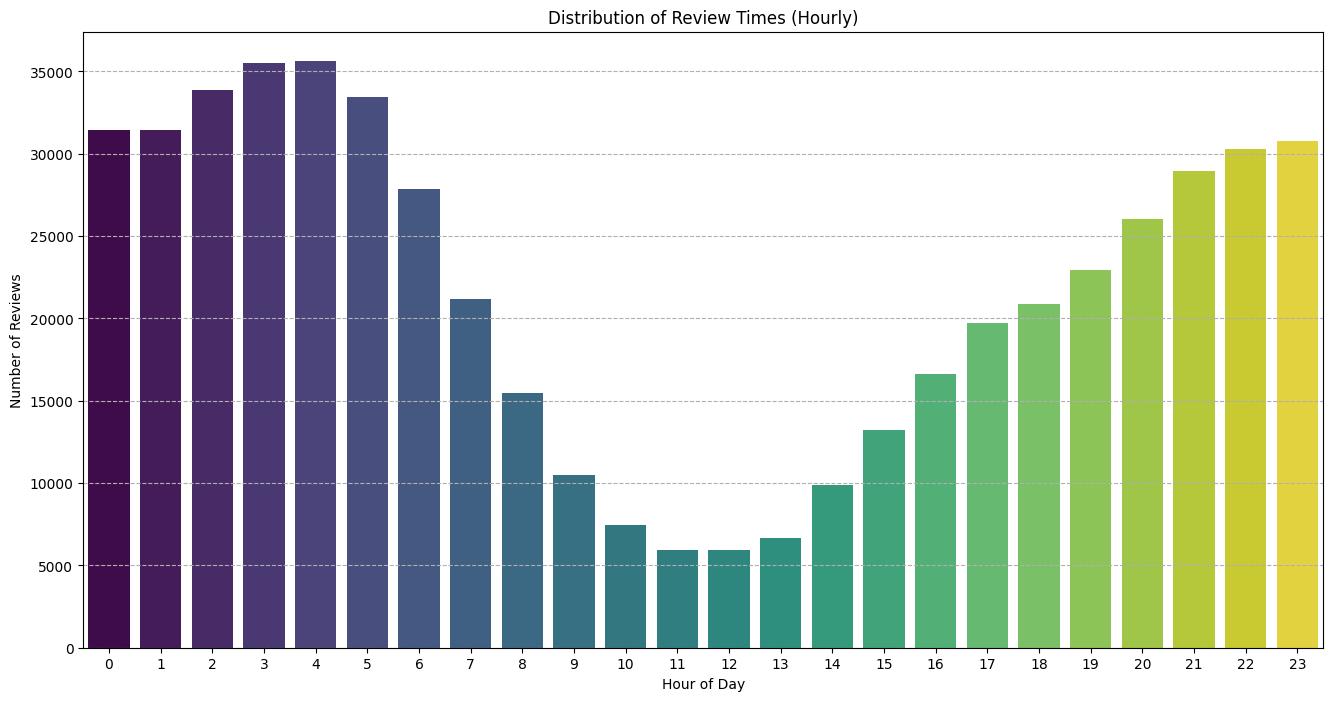

In [19]:

# Distribution of review times (hourly)
plt.figure(figsize=(16, 8))
sns.countplot(data=df, x='review_time', palette='viridis', hue='review_time', legend=False, order=range(24))
plt.title('Distribution of Review Times (Hourly)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

*  Curiously, the review count starts rising about 1pm and peaks at 3-4am before is starts going down

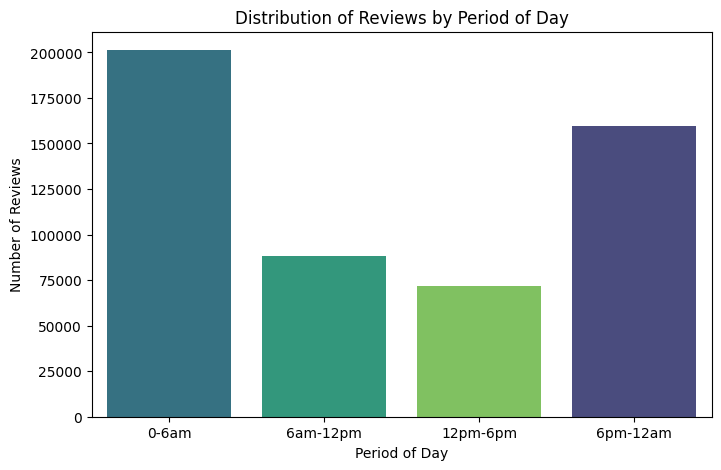

In [20]:
#  Distribution of reviews by period of day
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='period_of_day', order=['0-6am', '6am-12pm', '12pm-6pm', '6pm-12am'], palette='viridis', hue = 'period_of_day', legend = False)
plt.title('Distribution of Reviews by Period of Day')
plt.xlabel('Period of Day')
plt.ylabel('Number of Reviews')
plt.show()



* Most reviews are between 12 midnight and 6am followed by between 6pm to 12am

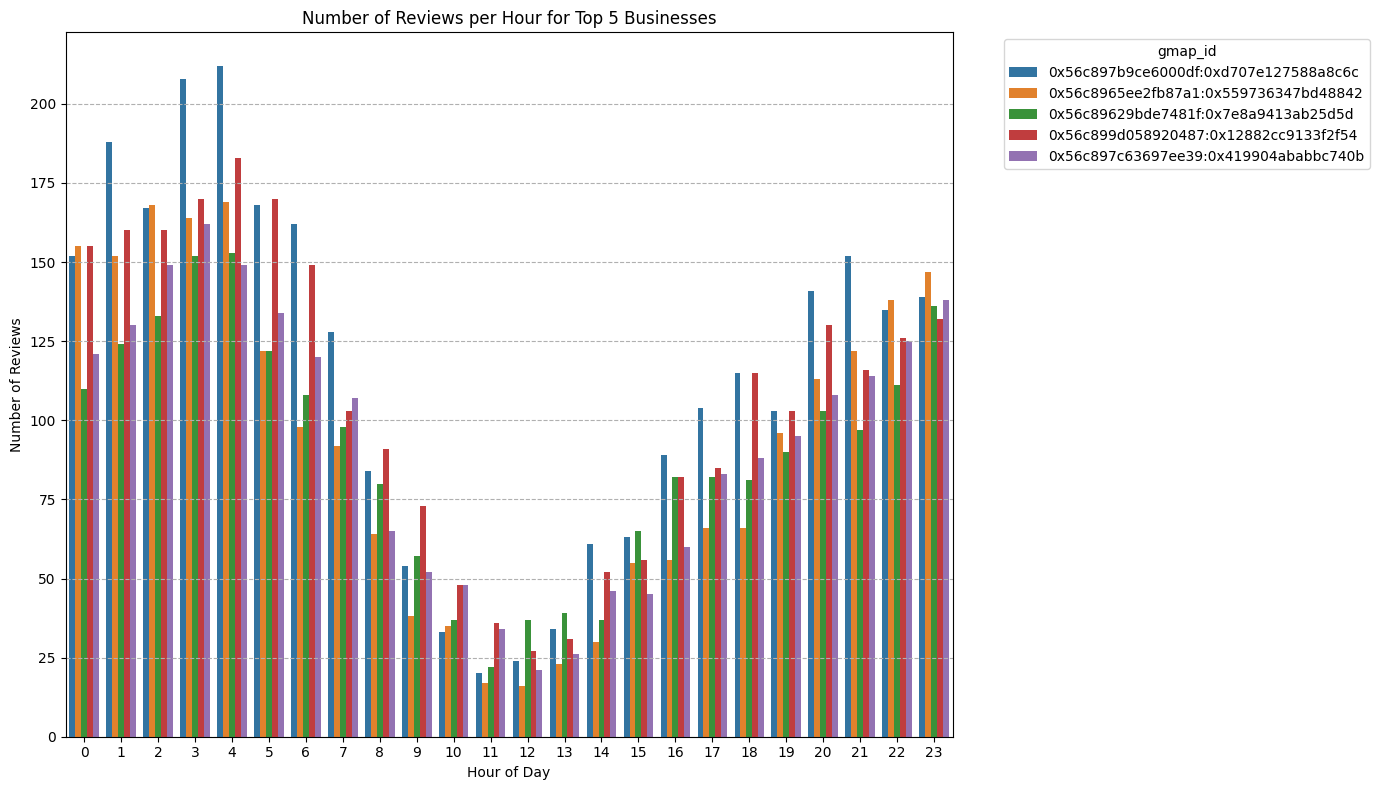

In [21]:
# Number of reviews per hour for a sample of gmap_ids
# Select top 5 gmap_ids with most reviews for demonstration. Remove null gmap_id
top_gmap_ids = review_counts.filter(col('gmap_id').isNotNull()).orderBy('review_count', ascending=False).limit(5).toPandas()['gmap_id'].tolist()

# Filter the pandas DataFrame for these top gmap_ids
df_top_gmap = df[df['gmap_id'].isin(top_gmap_ids)]

plt.figure(figsize=(14, 8))
sns.countplot(data=df_top_gmap, x='review_time', hue='gmap_id', palette='tab10', order=range(24))
plt.title('Number of Reviews per Hour for Top 5 Businesses')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.legend(title='gmap_id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

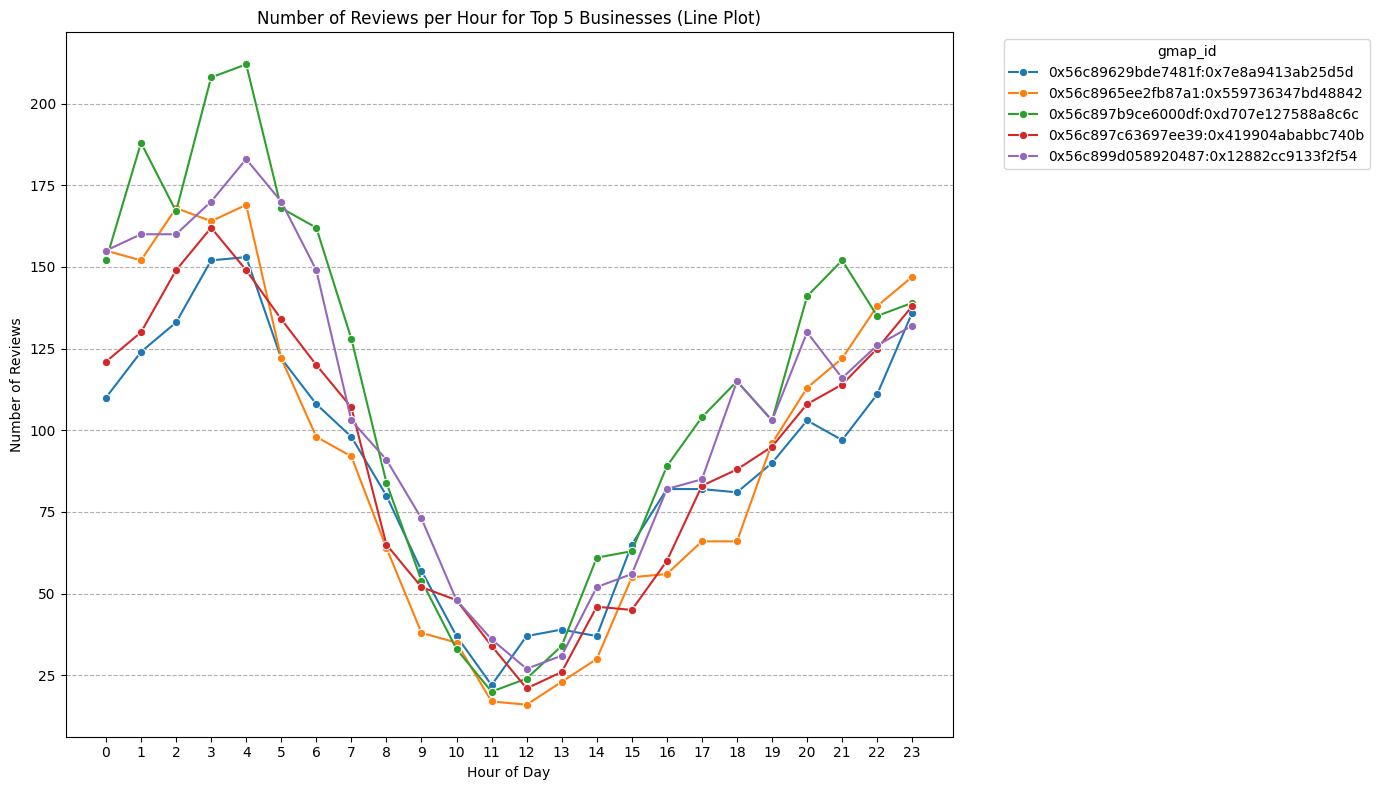

In [22]:
# Calculate the number of reviews per hour for each of the top gmap_ids
hourly_reviews_top_gmap = df_top_gmap.groupby(['gmap_id', 'review_time']).size().reset_index(name='review_count')

plt.figure(figsize=(14, 8))
sns.lineplot(data=hourly_reviews_top_gmap, x='review_time', y='review_count', hue='gmap_id', marker='o', palette='tab10')
plt.title('Number of Reviews per Hour for Top 5 Businesses (Line Plot)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reviews')
plt.xticks(range(24)) # Ensure all hours are shown on the x-axis
plt.grid(axis='y', linestyle='--')
plt.legend(title='gmap_id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



*   Still trough shape similar pattern as above
*   The number of review reaches the lowest point around midday



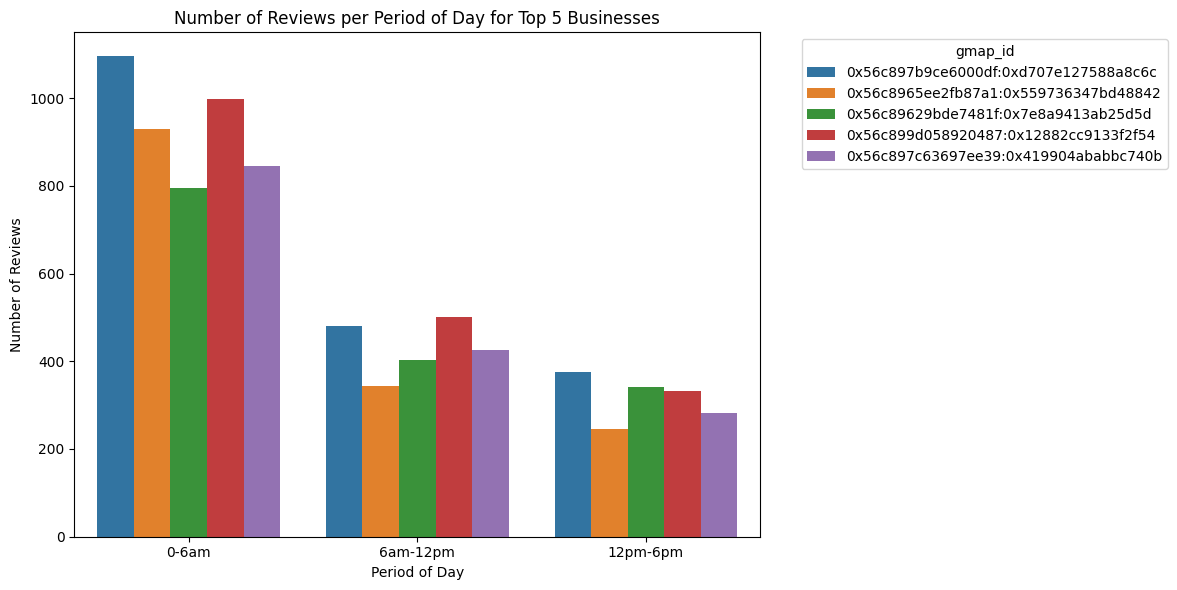

Number of businesses reviewed in the morning time (6am-12pm): 6732


In [23]:

# Number of reviews per period of day for a sample of gmap_ids
# Select top 5 gmap_ids with most reviews for demonstration

# Filter the pandas DataFrame for these top gmap_ids
#df_top_gmap = df[df['gmap_id'].isin(top_gmap_ids)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_top_gmap, x='period_of_day', hue='gmap_id', order=['0-6am', '6am-12pm', '12pm-6pm', '12pm-6pm'], palette='tab10')
plt.title('Number of Reviews per Period of Day for Top 5 Businesses')
plt.xlabel('Period of Day')
plt.ylabel('Number of Reviews')
plt.legend(title='gmap_id', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate and print the number of businesses reviewed in the morning time (6am-12pm)
morning_reviews_count = df[df['period_of_day'] == '6am-12pm']['gmap_id'].nunique()
print(f"Number of businesses reviewed in the morning time (6am-12pm): {morning_reviews_count}")

* Most reviews between 12am to 6am
* Number of businesses reviewed in the morning time (6am-12pm): 6732

## Answer 1.3

The current dataframe is df which is a pandas dataframe. we need to convert to spark dataframe before joining

In [24]:
spark_df = spark.createDataFrame(df)

In [25]:
# Alias the dataframes before joining to avoid ambiguous column names
review_df_aliased = spark_df.alias("review")
meta_review_business_df_aliased = meta_review_business_df.alias("meta")

# Perform an inner join on the 'gmap_id' column using aliased dataframes
joined_df = review_df_aliased.join(meta_review_business_df_aliased, on=col("review.gmap_id") == col("meta.gmap_id"), how='inner')

# Display the schema and first few rows of the joined DataFrame
joined_df.printSchema()
joined_df.show(5)

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- newtime: string (nullable = true)
 |-- review_time: long (nullable = true)
 |-- period_of_day: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: string (nullable = true)
 |-- num_of_reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: str

In [26]:
# Show the number of rows in the joined_df DataFrame
joined_row_count = joined_df.count()
print(f"Number of rows in joined_df: {joined_row_count}")

Number of rows in joined_df: 498626


* Some reviews would have been dropped due to lack of gmap_id

### 1.3.1

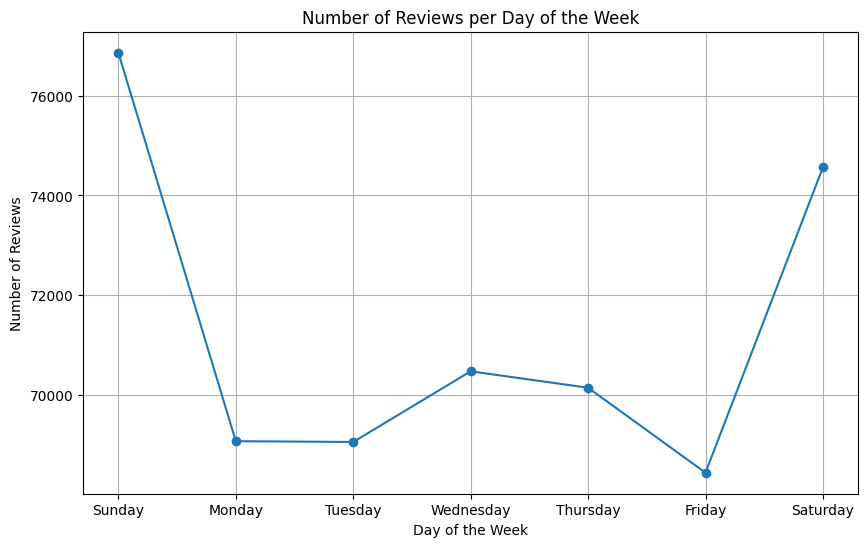

In [27]:


# Extract the day of the week from the 'newtime' column
# Sunday = 1, Monday = 2, ..., Saturday = 7
reviews_by_day = joined_df.withColumn('day_of_week', dayofweek(col('newtime')))

# Filter out rows where day_of_week is null before grouping
reviews_by_day_filtered = reviews_by_day.filter(col('day_of_week').isNotNull())

# Group by day of the week and count the reviews
reviews_by_day_count = reviews_by_day_filtered.groupBy('day_of_week').agg(count('*').alias('review_count'))

# Order by day of the week
reviews_by_day_count = reviews_by_day_count.orderBy('day_of_week')

# Convert to pandas DataFrame for plotting
reviews_by_day_pandas = reviews_by_day_count.toPandas()

# Map the day of the week number to names for better readability
day_names = {
    1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday',
    5: 'Thursday', 6: 'Friday', 7: 'Saturday'
}
reviews_by_day_pandas['day_of_week_name'] = reviews_by_day_pandas['day_of_week'].map(day_names)


# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(reviews_by_day_pandas['day_of_week_name'], reviews_by_day_pandas['review_count'], marker='o')
plt.title('Number of Reviews per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

* Most reviews were carried out on Sundays followed by Saturdays
* suprisingly Fridays has least of review count

### 1.3.2

In [28]:
# Add the day of the week column to joined_df
joined_df_with_day = joined_df.withColumn('day_of_week', dayofweek(col('newtime')))

# Filter for reviews on Sunday (day_of_week = 1) from the joined_df_with_day
sunday_reviews_df = joined_df_with_day.filter(col('day_of_week') == 1)

# Cast the 'rating' column to DoubleType for calculating average
sunday_reviews_df = sunday_reviews_df.withColumn('rating', col('rating').cast(DoubleType()))

# Calculate the average rating for each business on Sundays
avg_rating_sunday = sunday_reviews_df.groupBy(col('review.gmap_id')).agg(avg('rating').alias('average_sunday_rating'))

# Find the maximum average rating on Sunday
max_avg_rating_sunday = avg_rating_sunday.agg({'average_sunday_rating': 'max'}).collect()[0][0]

# Identify the gmap_id(s) with the highest average rating on Sunday
top_rated_gmap_ids_sunday = avg_rating_sunday.filter(col('average_sunday_rating') == max_avg_rating_sunday)

# Alias the dataframes before joining to avoid ambiguity
top_rated_gmap_ids_sunday_aliased = top_rated_gmap_ids_sunday.alias("top_rated")
meta_review_business_df_aliased = meta_review_business_df.alias("meta")


# Join with meta_review_business_df to get business names and categories
top_rated_businesses_sunday = top_rated_gmap_ids_sunday_aliased.join(
    meta_review_business_df_aliased,
    on=col("top_rated.gmap_id") == col("meta.gmap_id"),
    how='inner'
).select(
    col("meta.name"),
    col("meta.category"),
    col("top_rated.average_sunday_rating")
)

# Show the results
print("Businesses with the highest average ratings on Sunday and their categories:")
top_rated_businesses_sunday.show(truncate=False)

Businesses with the highest average ratings on Sunday and their categories:
+-------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+---------------------+
|name                                       |category                                                                                                                        |average_sunday_rating|
+-------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------+---------------------+
|Caffé D'arte Alaska                        |['Coffee shop']                                                                                                                 |5.0                  |
|Iron Asylum Gym AK                         |['Gym']                                                                                    

* The categorise wih highest ratings on sunday are Coffee shop, Gym and Gas Stations

### 1.3.3

Distribution of categories among businesses with highest average Sunday ratings:
+-------------------------------------+-----+
|category                             |count|
+-------------------------------------+-----+
|['Coffee shop']                      |24   |
|['Cannabis store']                   |20   |
|['Cafe']                             |18   |
|['Restaurant']                       |16   |
|['Barber shop']                      |15   |
|['Nail salon']                       |15   |
|['Hiking area']                      |15   |
|['Campground']                       |13   |
|['Auto repair shop']                 |12   |
|['Bar']                              |12   |
|['Tourist attraction']               |11   |
|['Non-profit organization']          |10   |
|['Gas station']                      |10   |
|['Beauty salon', 'Hair salon']       |10   |
|['Lake']                             |10   |
|['Hiking area', 'Tourist attraction']|10   |
|['Gift shop']                        |9    |

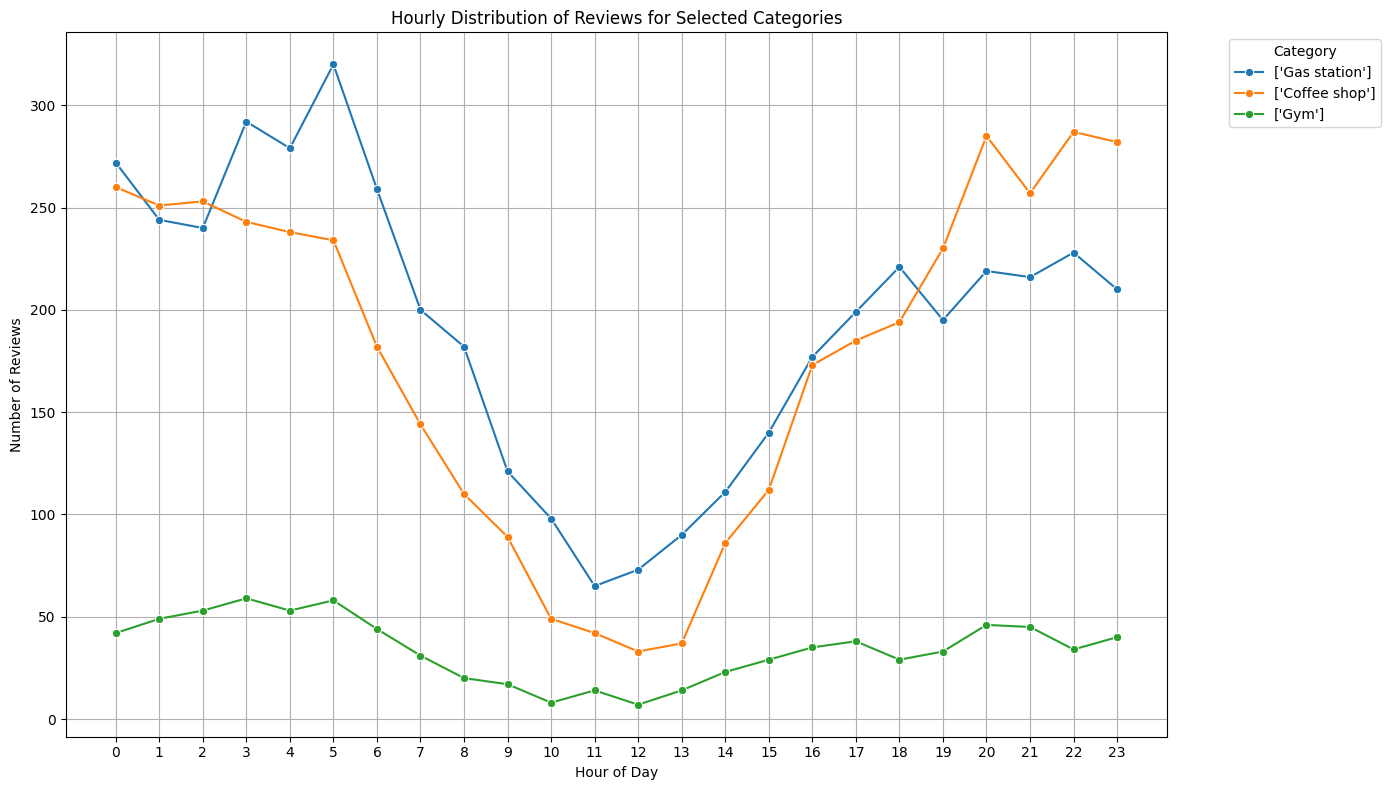

In [29]:

# Explore the distribution of categories among the top-rated businesses on Sunday
print("Distribution of categories among businesses with highest average Sunday ratings:")
top_rated_businesses_sunday.groupBy('category').count().orderBy('count', ascending=False).show(truncate=False)

# To explore peak hours for specific categories, we will pick categories from the top-rated list
# (Based on the previous output, 'Coffee shop', 'Gym', and 'Gas station' appear frequently)
categories_to_explore = ["['Coffee shop']", "['Gym']", "['Gas station']"]

# Filter the joined_df for the selected categories
filtered_df = joined_df_with_day.filter(col('category').isin(categories_to_explore))


# Group by category and hour, and count the reviews
category_hourly_reviews = filtered_df.groupBy('category', 'review_time').agg(count('*').alias('review_count'))

# Convert to pandas for plotting
category_hourly_reviews_pandas = category_hourly_reviews.toPandas()

# Plot the hourly distribution of reviews for each selected category
plt.figure(figsize=(14, 8))
sns.lineplot(data=category_hourly_reviews_pandas, x='review_time', y='review_count', hue='category', marker='o')
plt.title('Hourly Distribution of Reviews for Selected Categories')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reviews')
plt.xticks(range(24))
plt.grid(True)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

* For gas station and coffee shop peak at extreme ends of the day and dip towards midday. for gym , reltively flat curve an fewer reviews. More subtle dip at mid day

## Answer 1.4


Top 30 most common words:
great: 80651
good: 61911
food: 60870
place: 46149
service: 43820
staff: 27527
nice: 25593
friendly: 25509
always: 22771
best: 21185
love: 19408
get: 18782
time: 17290
go: 16231
like: 15049
one: 14191
amazing: 12110
clean: 12073
prices: 11758
awesome: 11746
really: 11726
people: 11627
store: 11423
well: 10825
back: 10312
helpful: 10141
excellent: 9970
little: 9766
selection: 9073
delicious: 9047


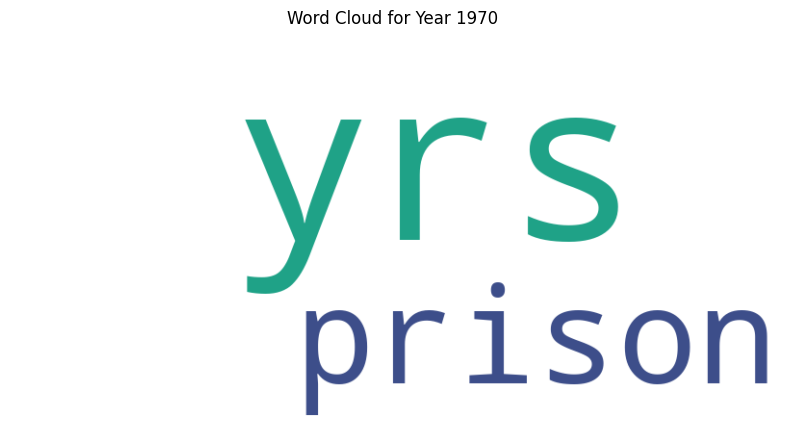

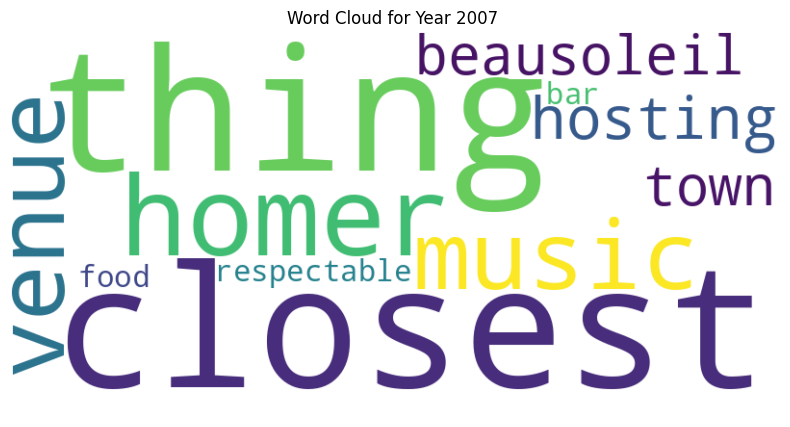

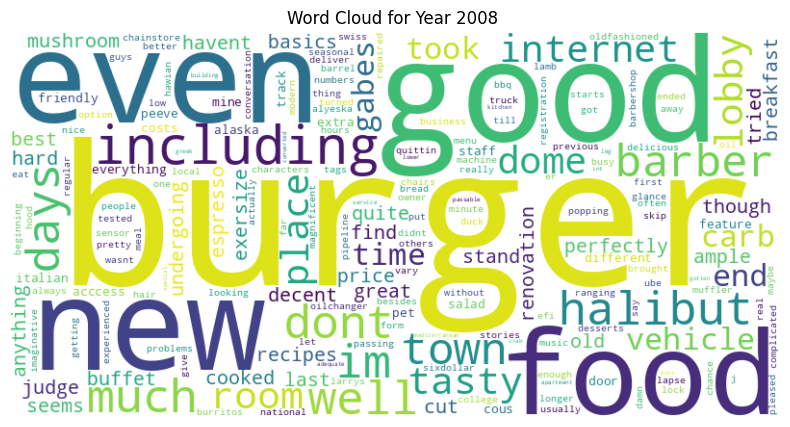

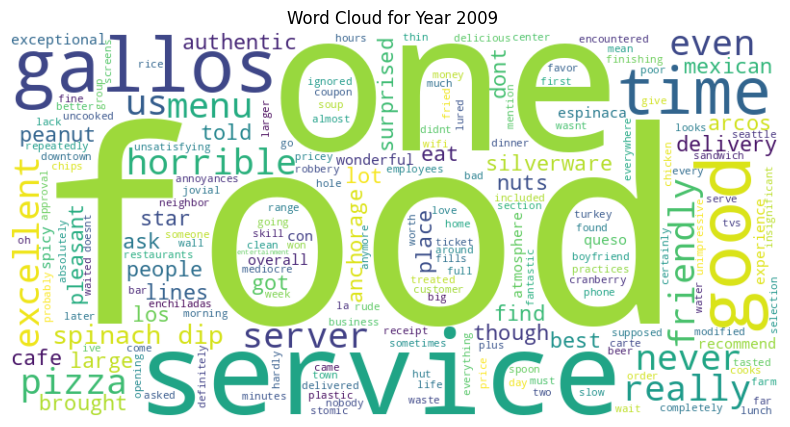

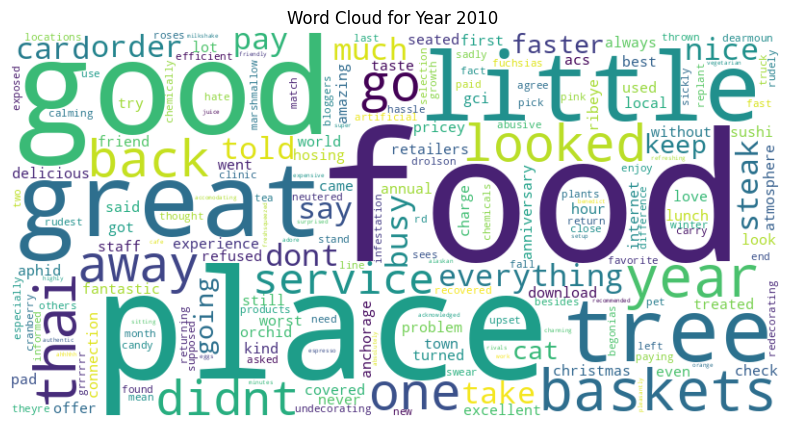

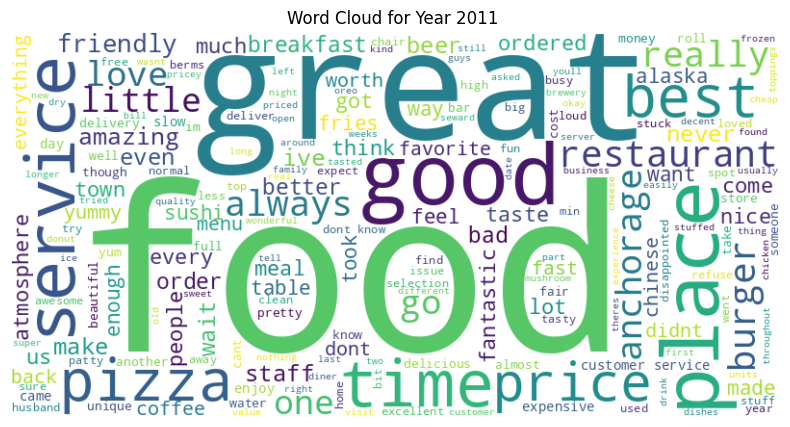

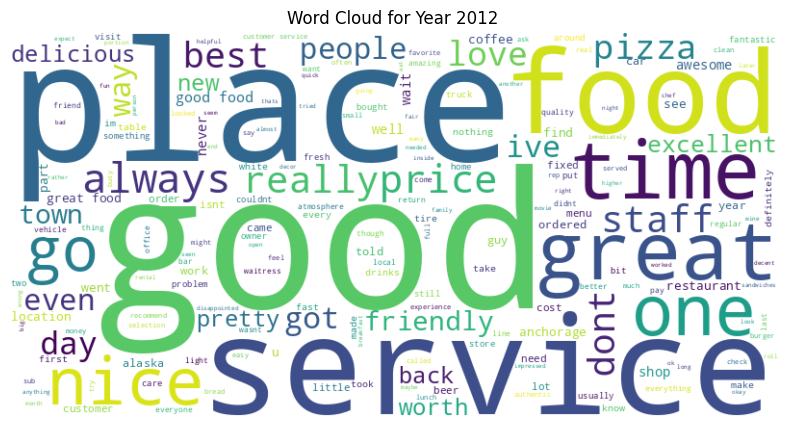

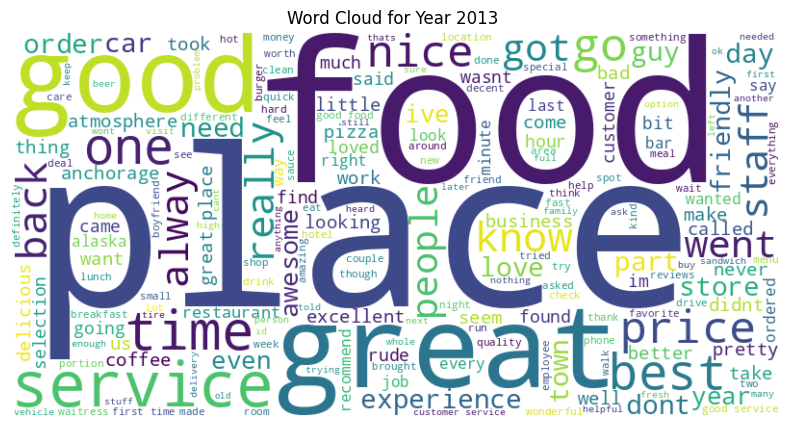

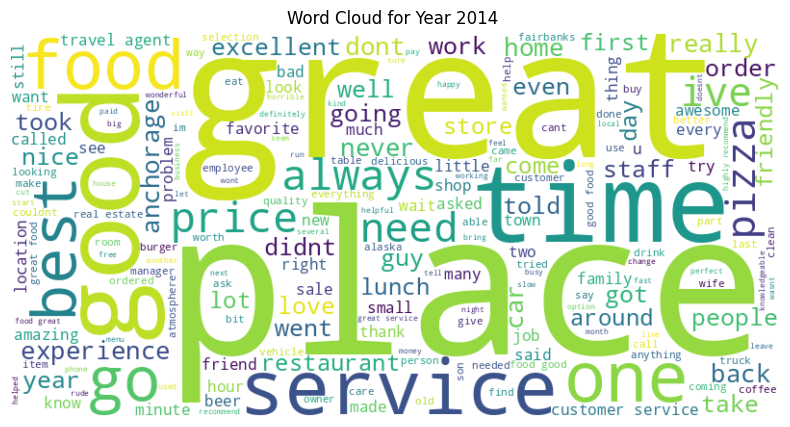

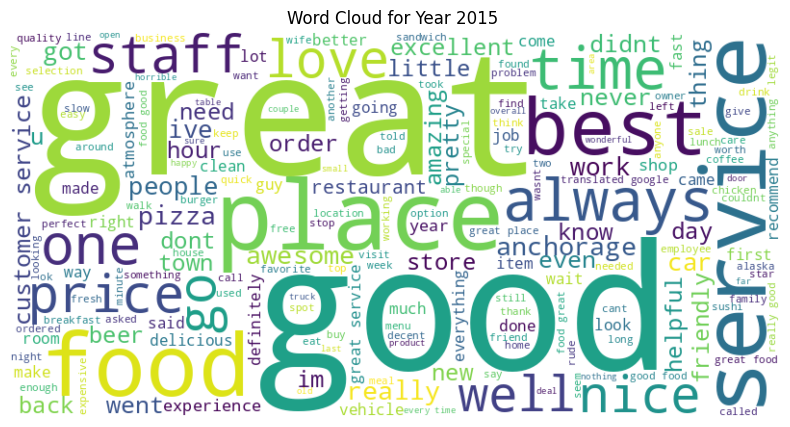

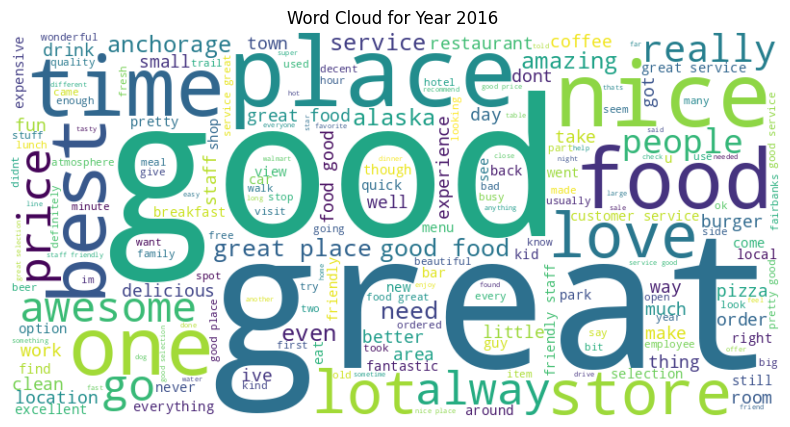

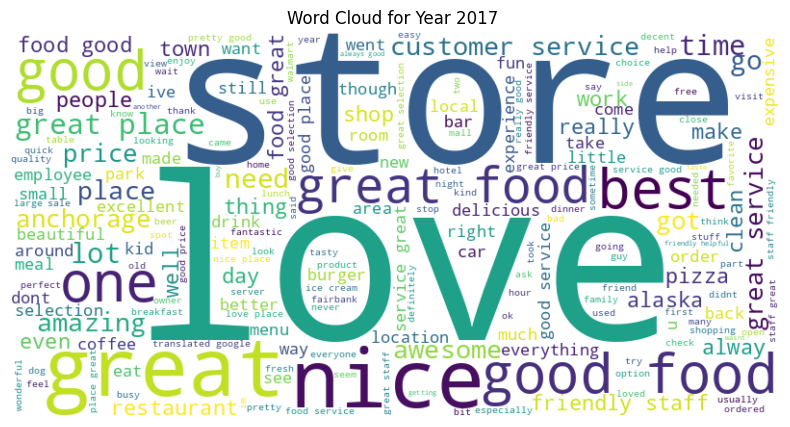

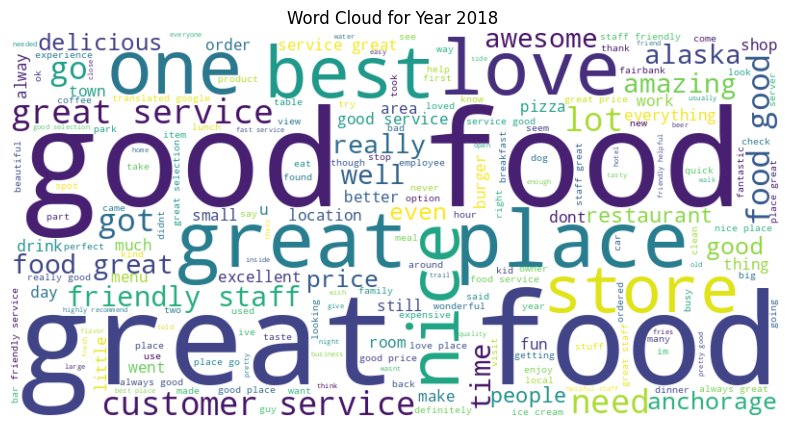

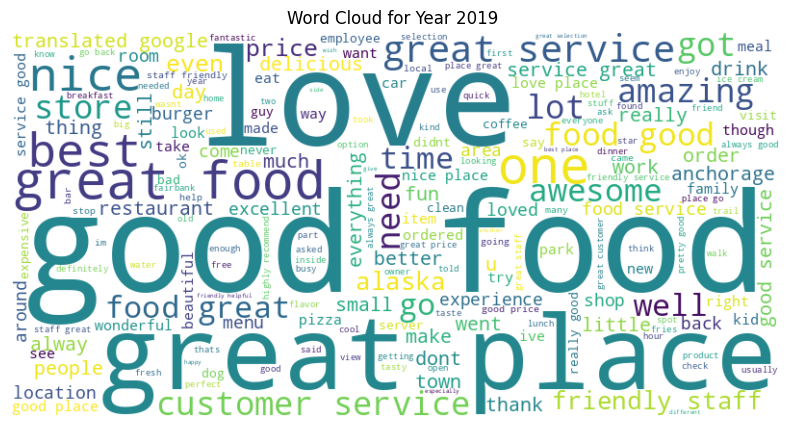

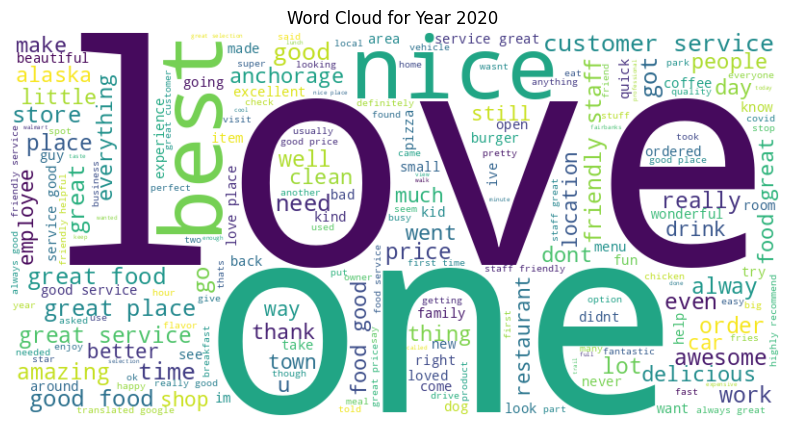

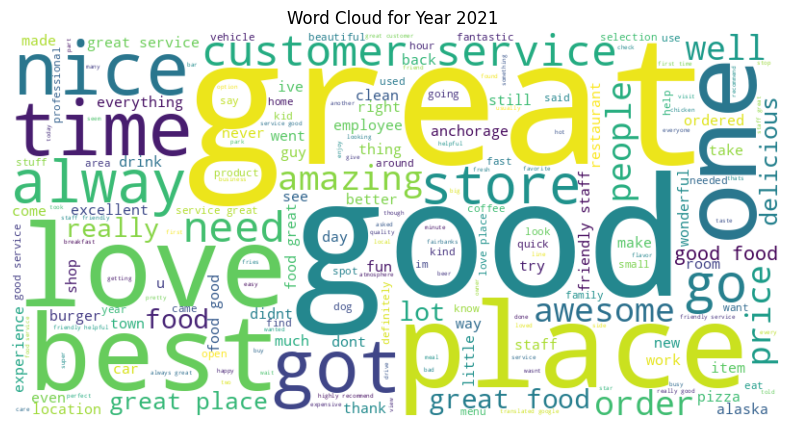

In [30]:
# Find the top 30 most common words
# Select the 'text' column and handle potential null values

# Select the 'text' column and filter out null values
reviews_text = review_df.select('text').filter(col('text').isNotNull())

# Tokenize the text, convert to lowercase, and remove punctuation
words_df = reviews_text.select(split(regexp_replace(lower(col('text')), '[^a-z\\s]', ''), '\\s+').alias('words'))

# Define custom stop words including 'review'
custom_stop_words = StopWordsRemover.loadDefaultStopWords("english") + ['review'] # Because we added 'no review' earlier

# Remove empty words and apply stop word removal
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=custom_stop_words)
words_df_filtered = remover.transform(words_df.filter(col('words').isNotNull()))

# Explode the array of filtered words
words_df_exploded = words_df_filtered.select(explode(col('filtered_words')).alias('filtered_word'))

# Filter out empty strings that might remain after explode and stop word removal
words_df_cleaned = words_df_exploded.filter(col('filtered_word') != '')


# Count the frequency of each word
word_counts = words_df_cleaned.groupBy('filtered_word').count()

# Get the top 30 most common words
top_30_words = word_counts.orderBy('count', ascending=False).limit(30).collect()

print("Top 30 most common words:")
for row in top_30_words:
    print(f"{row['filtered_word']}: {row['count']}")

# 2. Generate word clouds for different years
# Extract the year from the 'newtime' column
reviews_with_year = review_df.withColumn('review_year', year(col('newtime')))

# Filter out rows with null year or text
reviews_with_year = reviews_with_year.filter(col('review_year').isNotNull() & col('text').isNotNull())

# Tokenize, lowercase, remove punctuation, and remove stop words by year in Spark
reviews_with_year_and_filtered_words = reviews_with_year.select(
    'review_year',
    split(regexp_replace(lower(col('text')), '[^a-z\\s]', ''), '\\s+').alias('words')
)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=custom_stop_words)
reviews_with_year_and_filtered_words = remover.transform(reviews_with_year_and_filtered_words)

# Explode the filtered words and filter out empty strings
reviews_with_year_and_filtered_words = reviews_with_year_and_filtered_words.select(
    'review_year',
    explode(col('filtered_words')).alias('filtered_word')
).filter(col('filtered_word') != '')

# Collect filtered words by year, ordered by review_year
filtered_words_by_year_collected = reviews_with_year_and_filtered_words.groupBy('review_year').agg(collect_list('filtered_word').alias('filtered_words_list')).orderBy('review_year').collect()

# Generate and display word clouds for each year
for row in filtered_words_by_year_collected:
    year_val = row['review_year']
    filtered_words_list = row['filtered_words_list']

    if filtered_words_list:
        filtered_text_combined = " ".join(filtered_words_list)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text_combined)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Year {year_val} ')
        plt.show()

* The wordclouds show different popular review words for each year
* Entries were very sparse for some years like 1970 and 2007


## Answer 1.5


Businesses with the most unique reviewers:
+----------------------------+---------------------+
|name                        |unique_reviewer_count|
+----------------------------+---------------------+
|Walmart Supercenter         |6975                 |
|McDonald's                  |6855                 |
|Costco Wholesale            |4352                 |
|Carrs                       |4350                 |
|Taco Bell                   |4322                 |
|Fred Meyer                  |3597                 |
|Wendy's                     |3156                 |
|Safeway                     |2795                 |
|Moose's Tooth Pub & Pizzeria|2736                 |
|Subway                      |2732                 |
+----------------------------+---------------------+
only showing top 10 rows


Categories with the most unique reviewers:
+--------------------+---------------------+
|category_item       |unique_reviewer_count|
+--------------------+---------------------+
|Restauran

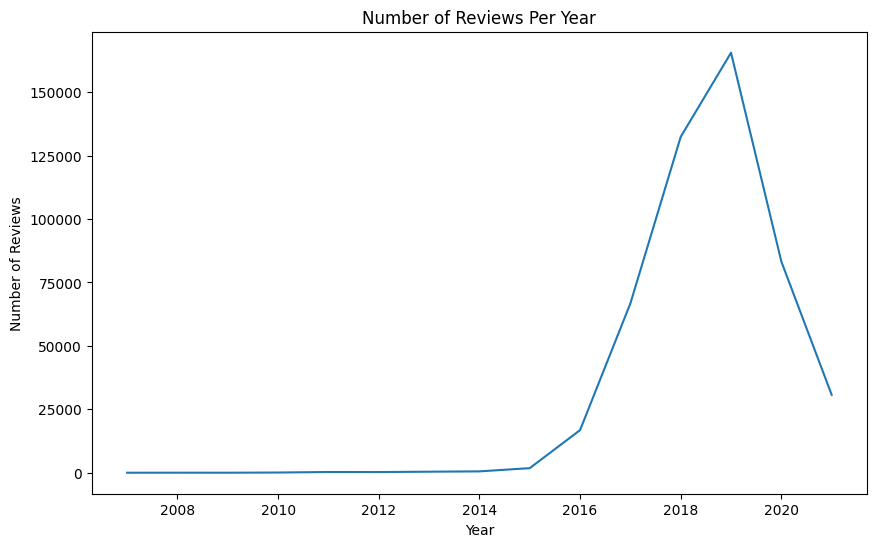

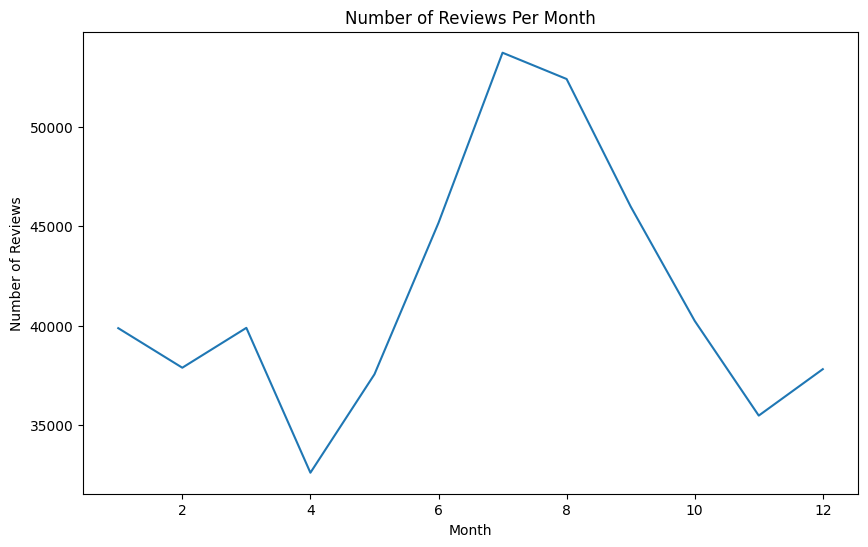

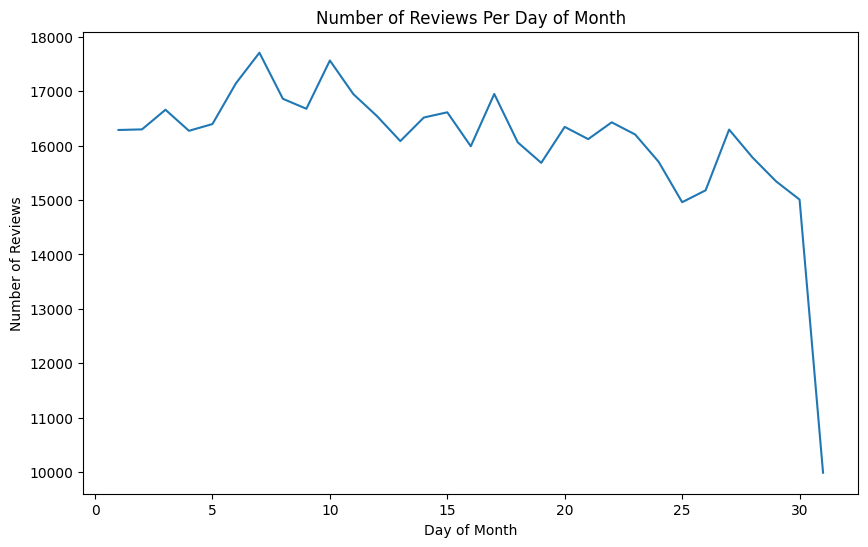

In [31]:

# Determine the number of unique reviewers per business (name)
# Reference the name column from the meta_review_business_df using its alias 'meta'
unique_reviewers_per_business = joined_df.groupBy(col('meta.name')).agg(countDistinct('user_id').alias('unique_reviewer_count'))

# Show the businesses with the highest distinct reviewer count
print("Businesses with the most unique reviewers:")
unique_reviewers_per_business.orderBy('unique_reviewer_count', ascending=False).show(10, truncate=False)

# Determine the number of unique reviewers per category
# Explode the category column first as it's an array/string representation of an array
from pyspark.sql.functions import explode, from_json
from pyspark.sql.types import ArrayType, StringType

# Attempt to parse the category string as a JSON array
joined_df_with_parsed_category = joined_df.withColumn(
    "parsed_category",
    from_json(col("meta.category"), ArrayType(StringType())) # Reference the category column from meta
)

# Explode the parsed category array
joined_df_exploded_category = joined_df_with_parsed_category.withColumn("category_item", explode(col("parsed_category")))


unique_reviewers_per_category = joined_df_exploded_category.groupBy('category_item').agg(countDistinct('user_id').alias('unique_reviewer_count'))

# Show the categories with the highest distinct reviewer count
print("\nCategories with the most unique reviewers:")
unique_reviewers_per_category.orderBy('unique_reviewer_count', ascending=False).show(10, truncate=False)

# Analyze temporal patterns of reviews
# Number of reviews per year
reviews_per_year = joined_df.withColumn('review_year', year(col('review.newtime'))).groupBy('review_year').count().orderBy('review_year')
print("\nNumber of reviews per year:")
reviews_per_year.show()

# Number of reviews per month
reviews_per_month = joined_df.withColumn('review_month', month(col('review.newtime'))).groupBy('review_month').count().orderBy('review_month')
print("\nNumber of reviews per month:")
reviews_per_month.show()

# Number of reviews per day of the month
reviews_per_day_of_month = joined_df.withColumn('review_day', dayofmonth(col('review.newtime'))).groupBy('review_day').count().orderBy('review_day')
print("\nNumber of reviews per day of the month:")
reviews_per_day_of_month.show()

# Number of reviews per hour (already done in Q1.2.3, but can be reiterated or plotted differently)
#reviews_per_hour = joined_df.withColumn('review_hour', hour(col('review.newtime'))).groupBy('review_hour').count().orderBy('review_hour')
#print("\nNumber of reviews per hour:")
#reviews_per_hour.show()

# Number of reviews per hour (already done in Q1.2.3, but can be reiterated or plotted differently)
reviews_per_hour = joined_df.groupBy('review_time').count().orderBy('review_time')
print("\nNumber of reviews per hour:")
reviews_per_hour.show()

# You can also plot these temporal patterns for better visualization
# For example, plotting reviews per year
reviews_per_year_pandas = reviews_per_year.toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(data=reviews_per_year_pandas, x='review_year', y='count')
plt.title('Number of Reviews Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

# Plot reviews per month
reviews_per_month_pandas = reviews_per_month.toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(data=reviews_per_month_pandas, x='review_month', y='count')
plt.title('Number of Reviews Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()

# Plot reviews per day of the month
reviews_per_day_of_month_pandas = reviews_per_day_of_month.toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(data=reviews_per_day_of_month_pandas, x='review_day', y='count')
plt.title('Number of Reviews Per Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Number of Reviews')
plt.show()

* Businesses with the most unique reviewers are Walmart Supercenter, Macdonald's, Costco Wholesale and Carrs.
This may signify acquisition of new customers by this business.

* Categories with the most unique reviewers are Restaurant, American restaurant, Fast food restaurant, Breakfast restaurant and Grocery store
The restaurants should ideally be grouped into one category

* Number of reviews per year was relatively low and flat until 2015 when there was sharp increase which peaked at 2019 before reduction up to 2021
Reviews peaked at the seventh month which may be holiday season in some settings (summer)
* Review by month shows almost uniform trend except the dip at 31 day. This is expect since not all months get to 31 days


## Answer 1.6


### 1.6.1

## **Spark Alternating Least Squares Algorithm**
Spark's implementation of the Alternating Least Squares (ALS) algorithm provides a scalable and efficient way to perform collaborative filtering for building **recommender systems**. It's designed to handle large datasets by leveraging Spark's distributed computing framework.

### **How It Works**

Collaborative filtering, a popular technique for recommendation engines, is based on the idea that users with similar tastes will like similar items. It can be a challenge to apply this concept to large-scale data, which is where Spark's ALS shines.

* **Matrix Factorization:** At its core, ALS is a **matrix factorization** algorithm. It takes a sparse user-item-rating matrix (where most entries are unknown) and decomposes it into two lower-dimensional matrices: a **user-feature matrix** and an **item-feature matrix**. These "features" are not human-interpretable but represent latent factors that capture user preferences and item characteristics. For a given user and item, the predicted rating is simply the dot product of their respective feature vectors.

* **Alternating Least Squares:** The algorithm gets its name from its iterative process. It "alternates" between two steps:  
  1. **Fixing the item-feature matrix**, it solves for the optimal user-feature matrix by minimizing the squared error of the observed ratings. This is a linear least squares problem for each user.  
  2. **Fixing the user-feature matrix**, it then solves for the optimal item-feature matrix, again minimizing the squared error. This is a linear least squares problem for each item.

This process continues until the model converges or a specified number of iterations are completed. The **parallelization** capabilities of Spark are crucial here, as it can solve for the user and item factors across different machines in a cluster, making it highly efficient for massive datasets.

---

### **Key Parameters and Benefits**

The ALS class in Spark MLlib has several important parameters you can tune to optimize performance:

* rank: The number of latent factors (features) to use. A higher rank can capture more complex relationships but increases computation time and can lead to overfitting.

* regParam: The regularization parameter, which helps prevent overfitting by penalizing large factor values.

* maxIter: The maximum number of iterations to run.

* coldStartStrategy: A strategy for handling new users or items that have no ratings in the training data. Common strategies include "drop" (to ignore them) or "NaN" (to return a Not a Number value).

Using Spark ALS for collaborative filtering offers significant advantages:

* **Scalability:** It's designed to run on a distributed computing cluster, allowing it to handle datasets with millions or even billions of ratings.

* **Efficiency:** The blocked implementation of ALS in Spark leverages in-memory computation, which is much faster than traditional disk-based methods.  
* **Flexibility:** It can handle both **explicit feedback** (e.g., star ratings) and **implicit feedback** (e.g., clicks, purchases).

### 1.6.2


In [32]:
# We are using Sparks ALS since our dataset is large. It  is a more scalable
# and recommended approach for collaborative filtering compared to a manual KNN implementation
# which can be computationally expensive on large datasets.



from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Prepare the data for ALS: ALS requires user, item, and rating columns as numerical indices.
# We need to convert 'user_id' and 'gmap_id' to numerical indices using StringIndexer.

# Filter out rows with null gmap_id or user_id as they cannot be used for recommendations
# Explicitly select the gmap_id from the review side to avoid ambiguity
recommendation_df = joined_df.filter(col('review.gmap_id').isNotNull() & col('user_id').isNotNull()).select(
    col('user_id'),
    col('review.gmap_id'), # Select gmap_id from the review side
    col('rating'),
    col('text') # Include other relevant columns if needed later
)


# Cast the rating column to a numeric type (float)
recommendation_df = recommendation_df.withColumn('rating', col('rating').cast('float'))

# Drop rows with null ratings after casting
recommendation_df = recommendation_df.filter(col('rating').isNotNull())

# Print the schema of the recommendation_df to check column names
print("Schema of recommendation_df:")
recommendation_df.printSchema()


# Index the user_id and gmap_id columns
user_indexer = StringIndexer(inputCol="user_id", outputCol="userIndex")
gmap_indexer = StringIndexer(inputCol="gmap_id", outputCol="gmapIndex")


# Create a pipeline to index the data
indexing_pipeline = Pipeline(stages=[user_indexer, gmap_indexer])
# Fit the pipeline and reassign the variable to the fitted model
indexing_pipeline = indexing_pipeline.fit(recommendation_df)
indexed_df = indexing_pipeline.transform(recommendation_df)

# Select and rename columns to match ALS expected input
als_input_df = indexed_df.select(
    col("userIndex"),
    col("gmapIndex"),
    col("rating").alias("rating") # Explicitly alias rating column. very important
)


# Build the ALS model
# ALS is a matrix factorization technique commonly used for collaborative filtering
als = ALS(maxIter=5, regParam=0.09, coldStartStrategy="drop")
als.setUserCol("userIndex")
als.setItemCol("gmapIndex")
als.setRatingCol("rating")


# Split the data into training and testing sets
(training, test) = als_input_df.randomSplit([0.8, 0.2])

# Train the model
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# Generate top 10 business recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Generate top 10 user recommendations for each business
businessRecs = model.recommendForAllItems(10)

# Show some recommendations
print("\nUser recommendations (first 5 users):")
userRecs.show(5, truncate=False)

print("\nBusiness recommendations (first 5 businesses):")
businessRecs.show(5, truncate=False)

Schema of recommendation_df:
root
 |-- user_id: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- rating: float (nullable = true)
 |-- text: string (nullable = true)

Root-mean-square error = 0.9912824974445382

User recommendations (first 5 users):
+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userIndex|recommendations                                                                                                                                                                            |
+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1        |[{5488, 4.3904357}, {3903, 4.3192635}, {5916, 4.24237}, {5052, 4.204685}, {3555, 4.175903}, {5843, 4.159885}, {2386, 4.1

In [33]:
# To make recommendations for a specific user, we  would typically:
# Get the user index for the sample user using the fitted user_indexer
# Use the recommendForUserSubset method of the trained ALS model.


# Sample a user_id from the Spark DataFrame
sampled_user_id_row = joined_df.select("user_id").sample(withReplacement=False, fraction=0.01).take(1)

# Re-fit the pipeline within this cell to ensure we have the fitted model
user_indexer = StringIndexer(inputCol="user_id", outputCol="userIndex")
gmap_indexer = StringIndexer(inputCol="gmap_id", outputCol="gmapIndex")
indexing_pipeline_refitted = Pipeline(stages=[user_indexer, gmap_indexer]).fit(recommendation_df)

try:
    if sampled_user_id_row:
        sample_user_id = sampled_user_id_row[0]['user_id']

        # Create a Spark DataFrame for the sample user
        sample_user_df = spark.createDataFrame([(sample_user_id,)], ["user_id"])
        #Transform to get the user index using the fitted indexer from the pipeline
        # Access the fitted StringIndexer model from the pipeline's stages
        sample_user_indexed = indexing_pipeline_refitted.stages[0].transform(sample_user_df) # Fixed: Access the first stage (user_indexer) from the fitted pipeline
        # Get the user index
        sample_user_index = sample_user_indexed.collect()[0]['userIndex']
        # Create a DataFrame with the user index for recommendation
        sample_user_for_rec = spark.createDataFrame([(sample_user_index,)], ["userIndex"])

        # Generate recommendations for this specific user index
        specificUserRecs = model.recommendForUserSubset(sample_user_for_rec, 10)
        print(f"\nRecommendations for user {sample_user_id}:")
        specificUserRecs.show(truncate=False)
    else:
        print("\nCould not sample a user_id.")

except IndexError:
     print(f"\nUser ID {sample_user_id} not found in the dataset or could not be indexed.")
except Exception as e:
     print(f"An error occurred during sample user recommendation: {e}")


Recommendations for user 1.0817081076081974e+20:
+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userIndex|recommendations                                                                                                                                                                          |
+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|217      |[{4880, 4.9484406}, {3616, 4.6764817}, {5694, 4.65447}, {5514, 4.652085}, {5843, 4.6302996}, {5277, 4.6251173}, {5583, 4.6228395}, {5767, 4.61041}, {5270, 4.5901203}, {5793, 4.5835147}]|
+---------+---------------------------------------------------------------------------------------------------------------------------------------------------

- Interpreting ALS recommendations requires understanding the latent factors learned by the model.
- The recommendations are based on the predicted rating a user would give to a business.
- A higher predicted rating indicates a stronger recommendation.

## Answer 1.7


### 1.7.1

+----------------------------------+--------------+
|category_item                     |average_rating|
+----------------------------------+--------------+
|Machine shop                      |5.0           |
|Home inspector                    |5.0           |
|Dental implants provider          |5.0           |
|Training centre                   |5.0           |
|Diamond buyer                     |5.0           |
|Marriage or relationship counselor|5.0           |
|Debris removal service            |5.0           |
|Medical spa                       |5.0           |
|Dental laboratory                 |5.0           |
|MRI center                        |5.0           |
+----------------------------------+--------------+
only showing top 10 rows

+------------------------+------------------+
|category_item           |average_rating    |
+------------------------+------------------+
|Electric utility company|2.111111111111111 |
|Debt collection agency  |2.4444444444444446|
|Police departme

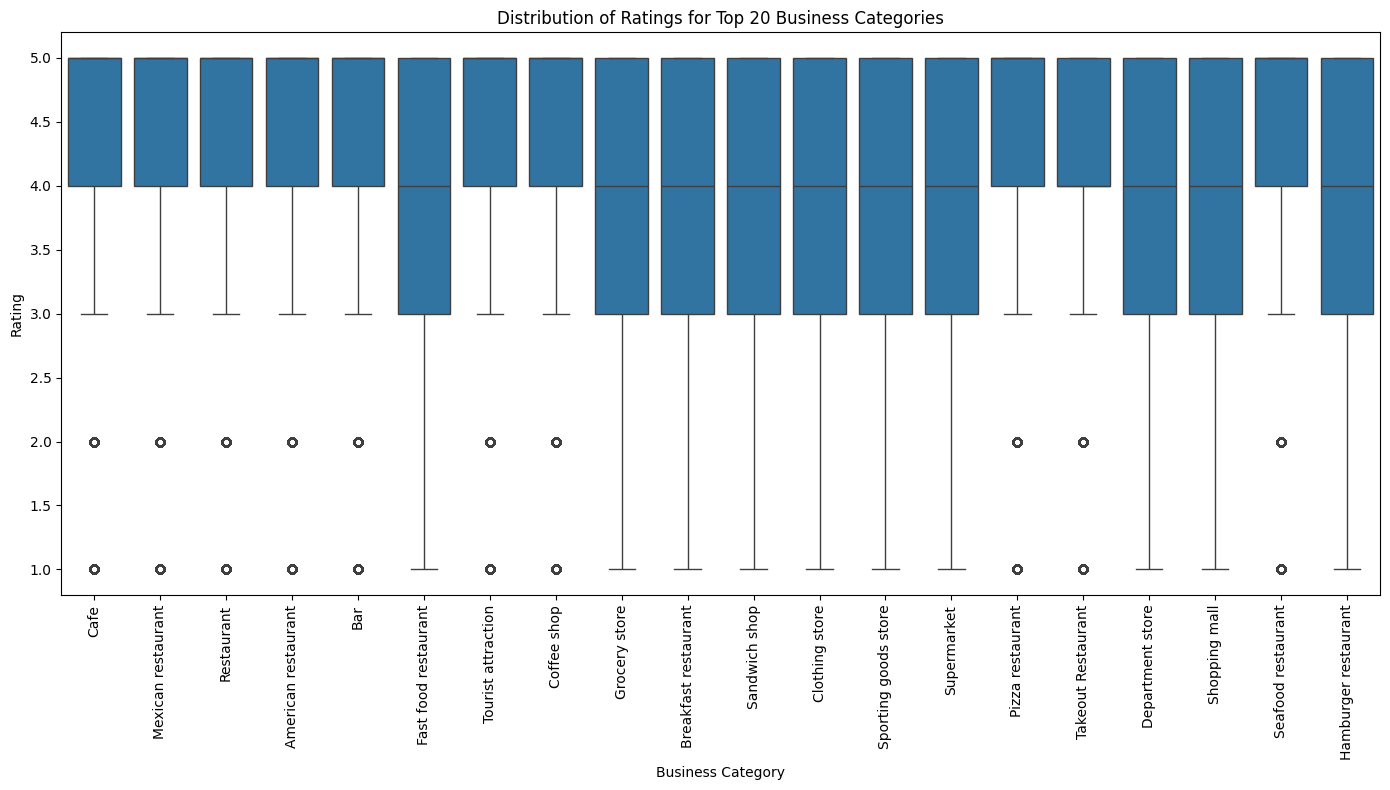

In [34]:
from pyspark.sql.functions import col, avg, explode, from_json
from pyspark.sql.types import ArrayType, StringType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Attempt to parse the category string as a JSON array and explode it
joined_df_with_parsed_category = joined_df.withColumn(
    "parsed_category",
    from_json(col("meta.category"), ArrayType(StringType()))
)

joined_df_exploded_category = joined_df_with_parsed_category.withColumn("category_item", explode(col("parsed_category")))

# Cast the rating column to DoubleType for calculating average
joined_df_exploded_category = joined_df_exploded_category.withColumn('rating', col('rating').cast(DoubleType()))

# Filter out rows with null ratings or category items
filtered_reviews = joined_df_exploded_category.filter(col('rating').isNotNull() & col('category_item').isNotNull())


# Calculate the average rating per category
average_rating_per_category = filtered_reviews.groupBy('category_item').agg(avg('rating').alias('average_rating'))

# Order by average rating and show the top/bottom categories
average_rating_per_category.orderBy('average_rating', ascending=False).show(10, truncate=False)
average_rating_per_category.orderBy('average_rating', ascending=True).show(10, truncate=False) #lowest rated businesses

# To visualize, let's consider the top N categories by number of reviews or by average rating.
# Let's get the count of reviews per category to select top categories for visualization
category_counts = filtered_reviews.groupBy('category_item').count().orderBy('count', ascending=False)

# Select the top N categories (e.g., top 20)
top_n_categories = category_counts.limit(20).toPandas()['category_item'].tolist()

# Filter the exploded dataframe to include only reviews from top N categories
filtered_reviews_top_categories = filtered_reviews.filter(col('category_item').isin(top_n_categories))

# Convert to pandas for plotting
filtered_reviews_top_categories_pandas = filtered_reviews_top_categories.toPandas()

# Create a box plot  to show the distribution of ratings per category limited to Top 20 categories
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_reviews_top_categories_pandas, x='category_item', y='rating')
plt.title('Distribution of Ratings for Top 20 Business Categories')
plt.xlabel('Business Category')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



* categories with the lowest average ratings Electric utility company, Debt collection agency, Police department, Passport office
* Distribution of the top 20 categories show ratings mostly above 3 out of 5 with very few outliers


### 1.7.2

In [35]:
from pyspark.sql.functions import col, split, explode, lower, regexp_replace
from pyspark.ml.feature import StopWordsRemover
from collections import Counter

# Define lower rating thresholds
lower_ratings_threshold = [1.0, 2.0] # can be adjusted based on need

# Filter the joined DataFrame for reviews with lower ratings
# Ensure the 'rating' column is cast to a numeric type for filtering
lower_rated_reviews_df = joined_df.withColumn('rating', col('rating').cast('double')).filter(col('rating').isin(lower_ratings_threshold))

# Select the 'text' column and handle potential null values
lower_rated_reviews_text = lower_rated_reviews_df.select('text').filter(col('text').isNotNull())

# Tokenize the text, convert to lowercase, and remove punctuation
words_df = lower_rated_reviews_text.select(split(regexp_replace(lower(col('text')), '[^a-z\\s]', ''), '\\s+').alias('words'))

# Define custom stop words. ( including 'review')
custom_stop_words = StopWordsRemover.loadDefaultStopWords("english") + ['review']

# Remove empty words and apply stop word removal
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=custom_stop_words)
words_df_filtered = remover.transform(words_df.filter(col('words').isNotNull()))

# Explode the array of filtered words
words_df_exploded = words_df_filtered.select(explode(col('filtered_words')).alias('filtered_word'))

# Filter out empty strings that might remain after explode and stop word removal
words_df_cleaned = words_df_exploded.filter(col('filtered_word') != '')

# Count the frequency of each word
word_counts = words_df_cleaned.groupBy('filtered_word').count()

# Get the top 30 most common words in lower-rated reviews
top_30_lower_rated_words = word_counts.orderBy('count', ascending=False).limit(30).collect()

print("Top 30 most common words in lower-rated reviews:")
for row in top_30_lower_rated_words:
    print(f"{row['filtered_word']}: {row['count']}")

# You can further analyze these words to identify themes.
# For instance, manually inspecting the words for common complaints.

Top 30 most common words in lower-rated reviews:
food: 5088
service: 3906
get: 2959
place: 2575
time: 2497
good: 2456
like: 2446
go: 2251
dont: 2119
one: 2102
back: 2017
never: 1883
order: 1804
even: 1693
got: 1692
didnt: 1607
customer: 1457
people: 1437
staff: 1266
bad: 1201
minutes: 1192
rude: 1183
went: 1170
us: 1163
said: 1090
store: 1090
told: 1086
way: 1068
going: 1048
ordered: 1032


Top 30 most common words in lower-rated reviews are food, service, get, place, and time


## Answer 1.8


### 1.8.1


In [36]:
from pyspark.sql.functions import collect_list, struct, col, sort_array

# Group by user_id and sort reviews within each group by time, then collect business names
user_business_history = joined_df.groupBy('user_id').agg(
    collect_list(
        struct(col('newtime'), col('meta.name'))
    ).alias('business_history')
)

# Sort the business history within each list by time
user_business_list_df = user_business_history.select(
    col('user_id'),
    sort_array(col('business_history')).alias('sorted_business_history')
).select(
    col('user_id'),
    col('sorted_business_history.name').alias('user_business_list')
)

# Show the result for a few users
print("Business history for a few users (sorted by time):")
user_business_list_df.show(truncate=False)

Business history for a few users (sorted by time):
+----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 1.8.2

In [37]:
from pyspark.sql.functions import col, size, array_distinct

# Calculate the number of elements in user_business_list before removing duplicates
user_business_list_df = user_business_list_df.withColumn(
    'original_count',
    size(col('user_business_list'))
)

# Remove duplicated business names from user_business_list
user_business_list_df = user_business_list_df.withColumn(
    'distinct_business_list',
    array_distinct(col('user_business_list'))
)

# Calculate the number of elements in the distinct business list
user_business_list_df = user_business_list_df.withColumn(
    'distinct_count',
    size(col('distinct_business_list'))
)

# Show the results for a few users (showing original and distinct counts)
print("Number of businesses reviewed by each user (original and distinct count):")
user_business_list_df.select('user_id', 'original_count', 'distinct_count').show(truncate=False)

# Show the distinct list for a few users
# print("\nDistinct business list for a few users:")
user_business_list_df.select('user_id', 'distinct_business_list').show(truncate=False)

Number of businesses reviewed by each user (original and distinct count):
+----------------------+--------------+--------------+
|user_id               |original_count|distinct_count|
+----------------------+--------------+--------------+
|1.0000609083371541e+20|47            |45            |
|1.0000684986283477e+20|10            |10            |
|1.000069682173995e+20 |19            |19            |
|1.0000719467235166e+20|15            |14            |
|1.00008316982005e+20  |22            |22            |
|1.0001122573921386e+20|8             |8             |
|1.000122992582312e+20 |35            |35            |
|1.0001363442299698e+20|11            |11            |
|1.0001542142415123e+20|13            |13            |
|1.0002309302239738e+20|32            |30            |
|1.0002378262815456e+20|13            |13            |
|1.0002613478726395e+20|34            |30            |
|1.0002625976454188e+20|18            |17            |
|1.0002645133665146e+20|13            |13     

### 1.8.3.1


**Strategy for User Similarity based on Reviewed Businesses**

**Approach:** Jaccard Similarity on Sets of Reviewed Businesses

**Explanation:**

1.  **Data Preparation:** We will use the `user_business_list_df` DataFrame, which contains a list of distinct businesses reviewed by each user in the `distinct_business_list` column.
2.  **Set Representation:** For each user, we will treat their `distinct_business_list` as a set of businesses they have interacted with.
3.  **Jaccard Similarity Calculation:** Jaccard similarity is a measure of similarity between two sets. For two sets A and B, the Jaccard similarity is calculated as the size of the intersection of the sets divided by the size of the union of the sets:

    


    $$ Jaccard(U,V) = \frac{|U \cap V|}{|U \cup V|} $$

    In our case, sets U and V will represent the distinct businesses reviewed by two different users. A higher Jaccard similarity score indicates a greater overlap in the businesses reviewed by the two users, suggesting higher similarity in their preferences or experiences.

4.  **Implementation:** We will iterate through pairs of users and calculate the Jaccard similarity between their respective sets of reviewed businesses. Due to the potentially large number of users, calculating all-pairs similarity can be computationally intensive. For demonstration, we can focus on calculating similarities for a subset of users or finding the most similar users for a few example users.

**Code Implementation Details:**

-   We will convert the `distinct_business_list` (which is a list) into a Python set for efficient set operations (intersection and union).
-   We will define a function to calculate Jaccard similarity between two user's business sets.
-   We will demonstrate the similarity calculation for a few pairs of users.

### 1.8.3.2

In [38]:
from pyspark.sql.functions import col
import itertools

# Convert the distinct business list to a Python set for each user
# This might be memory intensive for a very large number of users with extensive histories
user_business_sets = user_business_list_df.select('user_id', 'distinct_business_list').collect()
user_sets_dict = {row['user_id']: set(row['distinct_business_list']) for row in user_business_sets}

# Function to calculate Jaccard Similarity between two user's business sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    return intersection / union

# Example: Calculate similarity between a few pairs of users
# Get a list of user IDs
user_ids = list(user_sets_dict.keys())

# Select a few sample user ID pairs (replace with actual user IDs from your data if needed)
if len(user_ids) > 1:
    # Take the any two users as an example
    sample_user_id_1 = user_ids[10]
    sample_user_id_2 = user_ids[21]

    set1 = user_sets_dict.get(sample_user_id_1, set())
    set2 = user_sets_dict.get(sample_user_id_2, set())

    similarity_score = jaccard_similarity(set1, set2)
    print(f"Jaccard similarity between user {sample_user_id_1} and user {sample_user_id_2}: {similarity_score}")

    # You can add more pairs or implement a way to find top N similar users for a given user
    if len(user_ids) > 2:
        sample_user_id_3 = user_ids[41]
        set3 = user_sets_dict.get(sample_user_id_3, set())
        similarity_score_1_3 = jaccard_similarity(set1, set3)
        print(f"Jaccard similarity between user {sample_user_id_1} and user {sample_user_id_3}: {similarity_score_1_3}")

else:
    print("Not enough users to calculate similarity.")



Jaccard similarity between user 1.0002378262815456e+20 and user 1.0003810926081704e+20: 0.0
Jaccard similarity between user 1.0002378262815456e+20 and user 1.0007540861525744e+20: 0.0


* Very little overlap in business reviewed by users

# Part II

## Answer  2.1


Mean number of reviews per day: 160.89899967731526


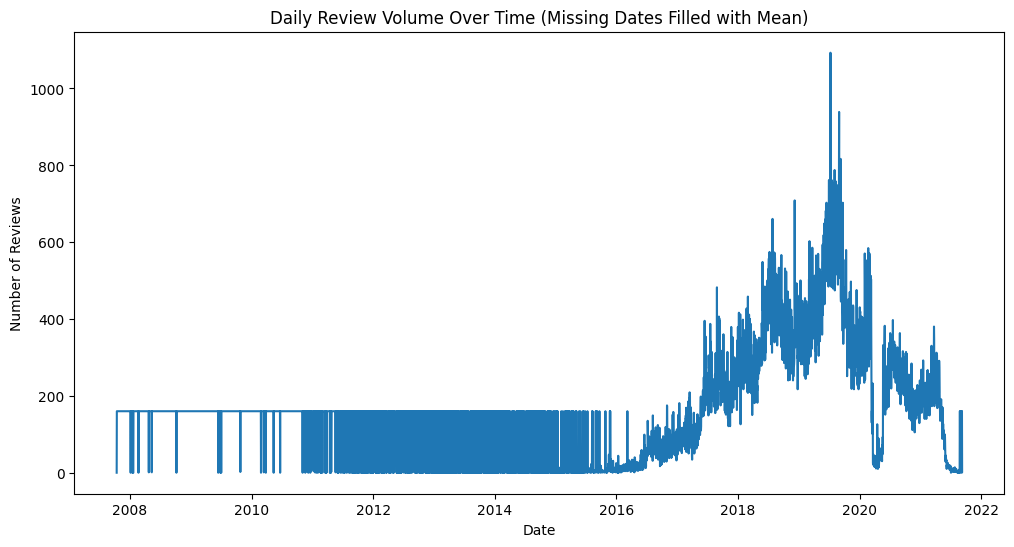

In [39]:
from pyspark.sql.functions import col, count, to_date
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Calculate total reviews per day
reviews_per_day = joined_df.groupBy('newtime').agg(count('*').alias('review_count')).orderBy('newtime')

# Convert to pandas DataFrame
reviews_per_day_pandas = reviews_per_day.toPandas()

# Ensure 'newtime' is datetime and set as index
reviews_per_day_pandas['newtime'] = pd.to_datetime(reviews_per_day_pandas['newtime'])
reviews_per_day_pandas = reviews_per_day_pandas.set_index('newtime')

# Calculate the mean number of reviews per day
mean_reviews_per_day = reviews_per_day_pandas['review_count'].mean()
print(f"Mean number of reviews per day: {mean_reviews_per_day}")

# Create a date range covering the entire period
min_date = reviews_per_day_pandas.index.min()
max_date = reviews_per_day_pandas.index.max()
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Reindex the DataFrame to include all dates and fill missing values with the mean
reviews_time_series = reviews_per_day_pandas.reindex(all_dates, fill_value=mean_reviews_per_day)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(reviews_time_series.index, reviews_time_series['review_count'])
plt.title('Daily Review Volume Over Time (Missing Dates Filled with Mean)')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()



- Observations up to 2011 appears sparse.
- It may be reasonable to filter out years before 2011 for purpose of time series analysis (ARIMA)

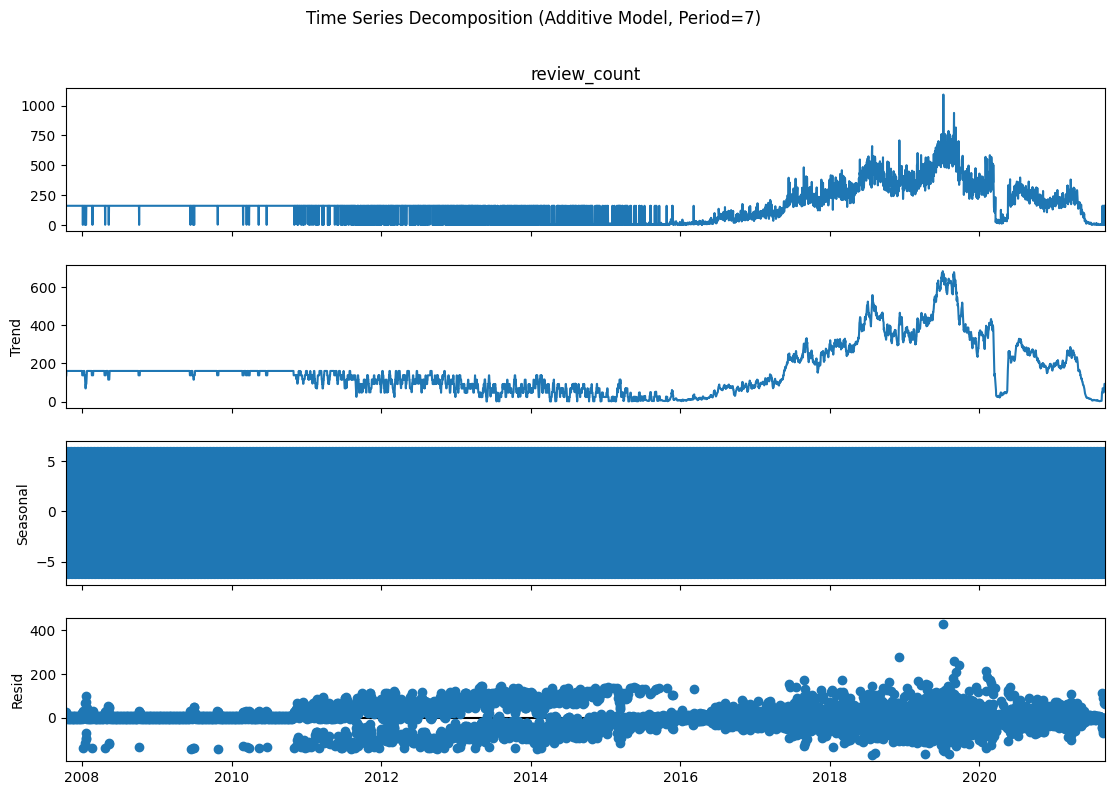


Seasonality component (first 14 days):
2007-10-13    2.451709
2007-10-14    6.318069
2007-10-15   -1.185671
2007-10-16   -1.808312
2007-10-17   -0.114163
2007-10-18    0.991069
2007-10-19   -6.652701
2007-10-20    2.451709
2007-10-21    6.318069
2007-10-22   -1.185671
2007-10-23   -1.808312
2007-10-24   -0.114163
2007-10-25    0.991069
2007-10-26   -6.652701
Freq: D, Name: seasonal, dtype: float64


In [40]:
# Decompose the time series Additive Moldel assuming an additive model and a seasonality period (e.g., daily or weekly)
# For longer-term seasonality, a larger period might be needed.
# Let's try weekly seasonality (period=7) first.
decomposition = seasonal_decompose(reviews_time_series['review_count'], model='additive', period=7)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition (Additive Model, Period=7)', y=1.02)
plt.show()

# Analyze the seasonality component. We will inspect the 'seasonal' component of the decomposition object
print("\nSeasonality component (first 14 days):")
print(decomposition.seasonal.head(14))



- weekly Seasonal decompositon (m=7) is inadequate to really show the seasonality in this data based on the solid block obtained

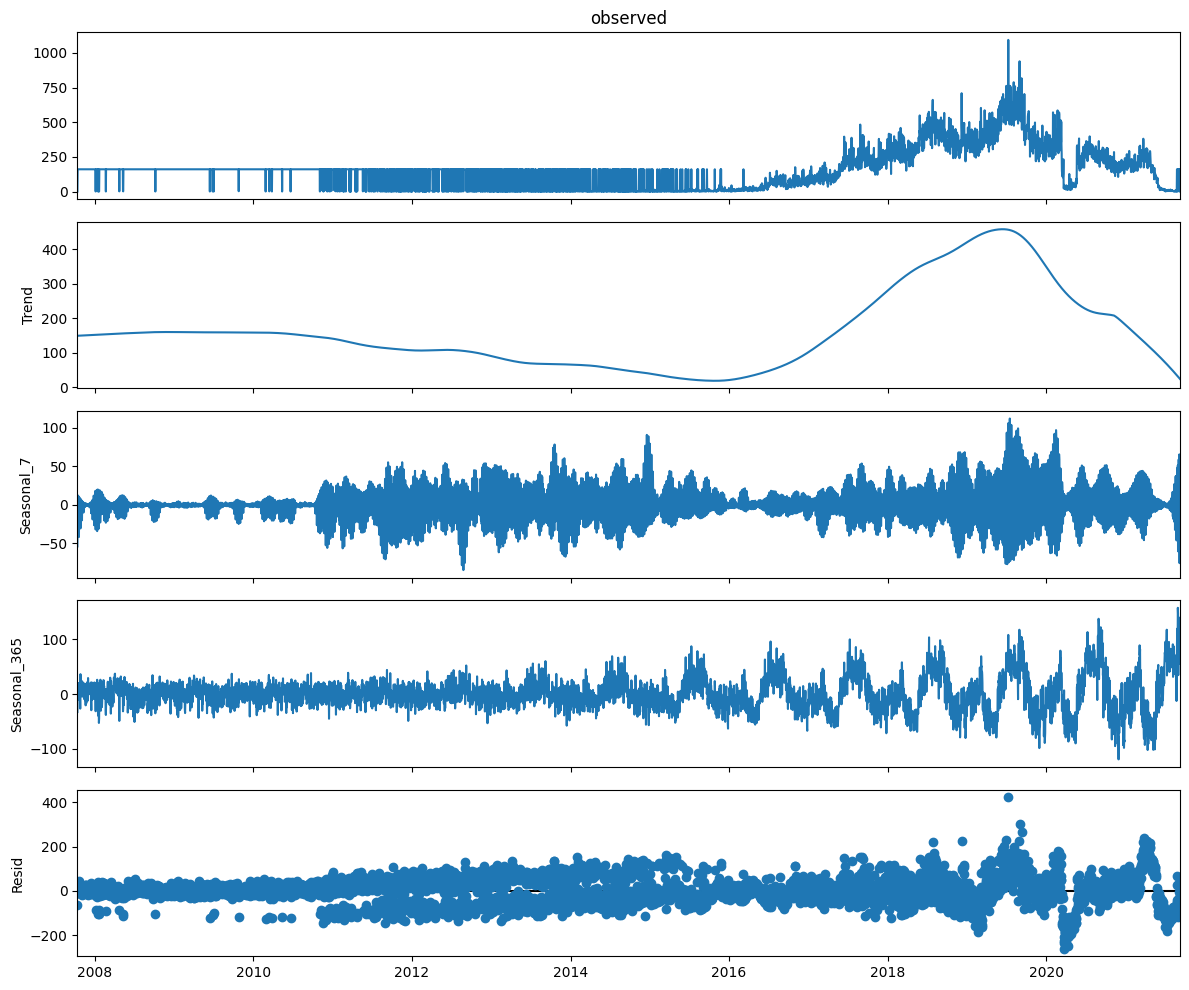

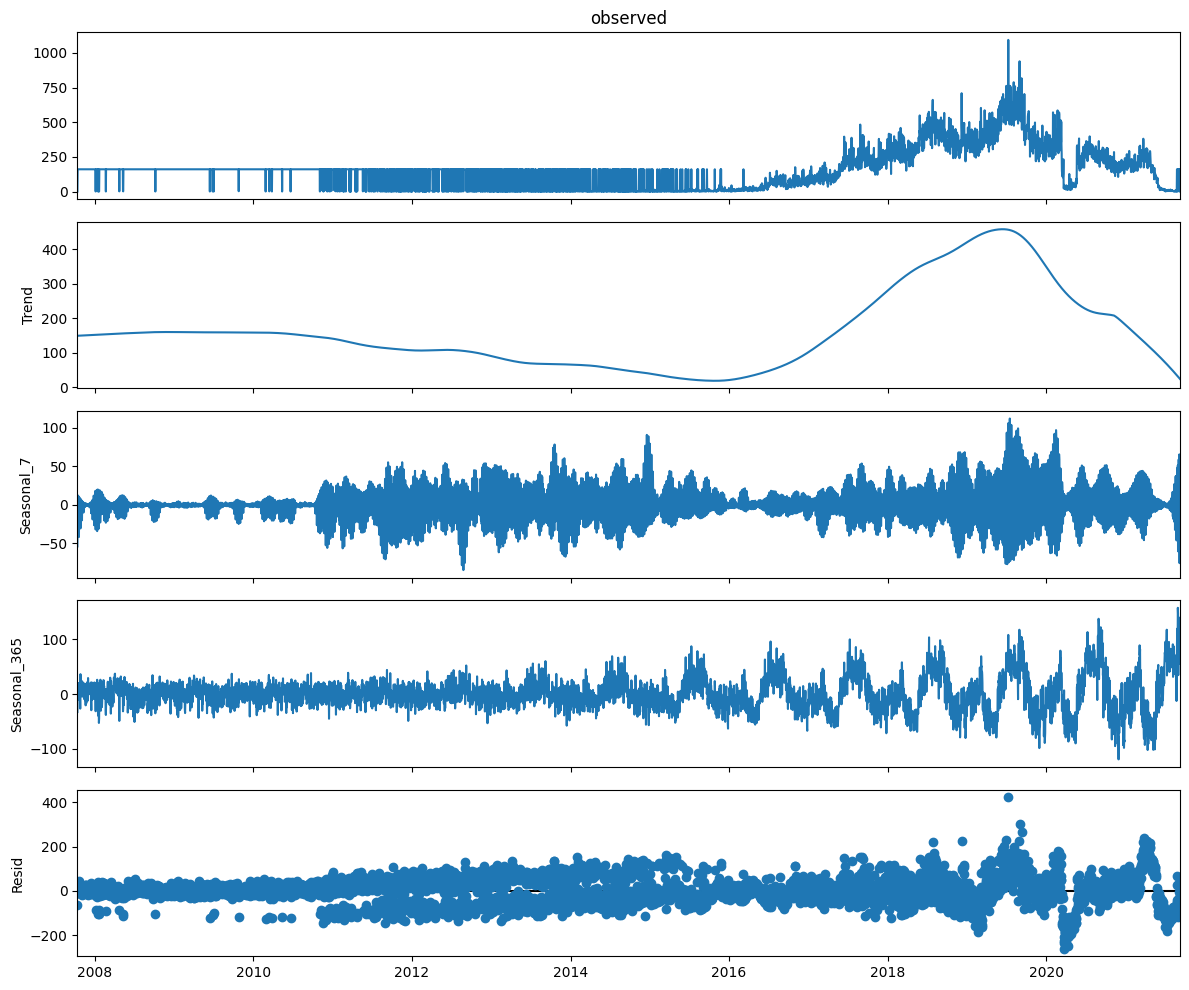

In [42]:
# Assuming your daily data is in a pandas Series named 'data_daily'
from statsmodels.tsa.seasonal import MSTL

# 365 is often used as a close approximation for simplicity
periods = [7, 365]

# Perform MSTL decomposition
result = MSTL(reviews_time_series['review_count'], periods=periods).fit()

# Plot the results to see the separate seasonal curves
# The output will show one plot for the Trend, one for Seasonal_7,
# one for Seasonal_365, and one for Residual.
plt.rcParams['figure.figsize'] = (12, 10)
result.plot()

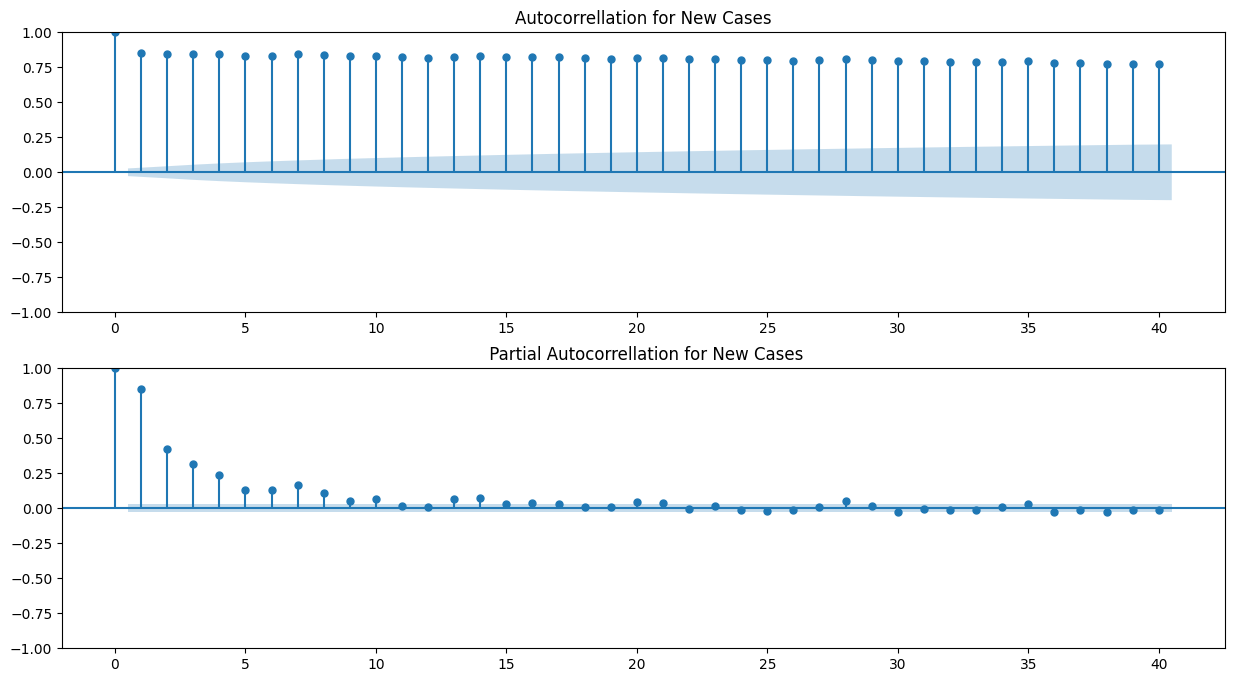

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


plt.figure(figsize=(15,8))
plt.subplot(211 )
#plot_acf(covid_data, lags=40, ax=plt.gca(), title="Autocorrellation for New Cases")
plot_acf(reviews_time_series, lags=40, ax=plt.gca(), title="Autocorrellation for New Cases")

plt.subplot(212)
#plot_pacf(covid_data, lags=40, ax=plt.gca(),title=" Partial Autocorrellation for New Cases" )
plot_pacf(reviews_time_series, lags=40, ax=plt.gca(),title=" Partial Autocorrellation for New Cases" )


plt.show()

## Answer 2.2


### 2.2a

In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Split the time series data into training and testing sets
# Using a simple train-test split, e.g., 80% for training and 20% for testing
train_size = int(len(reviews_time_series) * 0.8)
train, test = reviews_time_series[0:train_size], reviews_time_series[train_size:]

# Define the parameter grid for p, d, and q
p_values = d_values = q_values = [0, 1, 2]

# Perform grid search to find the best ARIMA model parameters
best_mae = float('inf')
best_order = None
warnings.filterwarnings("ignore") # Ignore warnings from ARIMA

print("Performing grid search for ARIMA parameters (p, d, q)...")

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Train the ARIMA model
                model = ARIMA(train, order=order)
                model_fit = model.fit()

                # Make predictions on the test set
                predictions = model_fit.predict(start=len(train), end=len(reviews_time_series)-1)

                # Evaluate the model using Mean Absolute Error
                mae = mean_absolute_error(test, predictions)

                # Check if this model has a lower MAE
                if mae < best_mae:
                    best_mae = mae
                    best_order = order
                    print(f"New best ARIMA model found: Order={best_order}, MAE={best_mae:.3f}")

            except Exception as e:
                # print(f"ARIMA model with order {order} failed: {e}")
                continue # Continue to the next parameter combination

print("\nGrid search complete.")
print(f"Best ARIMA Model Order: {best_order}")
print(f"Corresponding Mean Absolute Error (MAE): {best_mae:.3f}")

# You can now use the best_order to train the final ARIMA model on the entire dataset
# and make future forecasts if needed.

Performing grid search for ARIMA parameters (p, d, q)...
New best ARIMA model found: Order=(0, 0, 0), MAE=193.802
New best ARIMA model found: Order=(0, 0, 1), MAE=193.768
New best ARIMA model found: Order=(0, 0, 2), MAE=193.742
New best ARIMA model found: Order=(0, 1, 0), MAE=145.162
New best ARIMA model found: Order=(1, 0, 1), MAE=121.088

Grid search complete.
Best ARIMA Model Order: (1, 0, 1)
Corresponding Mean Absolute Error (MAE): 121.088


- the best model with lowest MAE is model with param (1, 0, 1) for p,d,q
- an exploration of larger parameter space might yield better result but I followed the specification in the question

###  2.2b
### **LSTM and RNN Time Series Forecasting Strategy**

### **1\. Data Wrangling**

The initial phase is critical for preparing time series data for a deep learning model. Unlike traditional machine learning, LSTMs and RNNs require data to be in a specific format.

* **Data Cleaning and Resampling:**  
  * Start by handling missing values and outliers in your time series data. Common techniques include interpolation (filling gaps based on surrounding data points) or forward/backward filling.  
  * Ensure the data has a **fixed, uniform frequency**. If your data is irregularly sampled (e.g., recorded at random intervals), you must resample it to a consistent time step (e.g., daily, hourly, or weekly) to create a clean, sequential dataset.  
* **Feature Engineering:**  
  * While deep learning models can learn features automatically, you can enhance performance by creating time-based features. These might include the day of the week, month, or year.  
  * If you have a multi-variate time series (data with more than one variable), you can use all variables as input features.  
* **Data Normalization:**  
  * LSTMs and RNNs are highly sensitive to the scale of input data. You **must** scale the data to a common range, such as \[0,1\] or a standard normal distribution. This step, often performed with a MinMaxScaler or StandardScaler, helps the model converge faster and improves stability.  
* **Sequence Creation (Sliding Window):**  
  * This is the most crucial step for preparing time series data for LSTMs/RNNs. You need to transform the flat time series into a supervised learning problem.  
  * Use a **sliding window** technique to create sequences of fixed length. Each sequence will serve as an input feature set (X), and the value immediately following the sequence will be the target (y).  
  * For example, if you have the sequence \[10, 12, 14, 16, 18, 20\] and a window size of 3, your training data would be:  
    * Input: \[10, 12, 14\] \-\> Output: 16  
    * Input: \[12, 14, 16\] \-\> Output: 18  
    * Input: \[14, 16, 18\] \-\> Output: 20  
  * The data then needs to be reshaped into a 3D array: \[samples, timesteps, features\].

### **2\. Modeling Steps**

Once your data is prepared, you can define, train, and evaluate your deep learning model.

* **Model Architecture:**  
  * **Simple RNN:** Use a simple RNN for straightforward tasks with short-term dependencies.  
  * **LSTM/GRU:** For problems with long-term dependencies, LSTMs (Long Short-Term Memory) or GRUs (Gated Recurrent Units) are preferred. Their internal "gates" allow them to selectively remember and forget information over long sequences, solving the vanishing gradient problem of simple RNNs.  
  * **Layer Stacking:** For more complex patterns, you can stack multiple LSTM or RNN layers. The first layer should have return\_sequences=True to pass its output to the next layer. The final LSTM/RNN layer should have return\_sequences=False before connecting to the dense output layer.  
  * **Output Layer:** The final layer is typically a Dense layer with a single neuron, as you are forecasting a single value.  
* **Model Compilation:**  
  * Choose an **optimizer** (e.g., Adam or RMSprop), which determines how the model updates its weights to minimize the loss.  
  * Select a **loss function** (e.g., Mean Squared Error for regression problems).  
  * Define **metrics** to monitor during training, such as RMSE or Mean Absolute Error.  
* **Model Training:**  
  * Train the model using the prepared (X, y) training data.  
  * Specify the number of **epochs** (how many times the model sees the entire dataset) and a **batch size** (the number of samples processed before the model's weights are updated).  
  * Use a **validation set** to monitor the model's performance on unseen data and prevent overfitting.  
* **Prediction and Evaluation:**  
  * After training, use your model to make predictions on the test set.  
  * To evaluate the forecast accuracy, you will need to **un-normalize** the predictions back to the original scale.  
  * Calculate evaluation metrics like RMSE or MAE on the un-normalized values to understand the model's performance in real-world units.  
* **Multi-Step Forecasting:**  
  * If you need to forecast multiple steps into the future, you can use a recursive approach.  
  * Predict the next value, then append it to your input sequence, and use this new, updated sequence to predict the subsequent value. This process is repeated for as many steps as you need to forecast.

Daily review volume data was prepared for time series analysis by filling missing dates with the mean number of reviews per day.



Grid Search: A grid search was performed to find the optimal parameters (p, d, q) for an ARIMA model .


Best Model: The best model found was ARIMA(1, 0, 1), which yielded the lowest Mean Absolute Error (MAE) of 121.088.

Deep Learning Time Series Forecasting
The report also discusses an alternative approach using deep learning models like LSTM and RNNs.

Data Wrangling: This involves data cleaning (handling outliers), resampling to a uniform frequency, and data normalization (e.g., using MinMaxScaler) . A crucial step is using a

sliding window technique to transform the data into sequences for supervised learning .


Modeling: The model architecture would consist of LSTM or RNN layers, followed by a dense output layer. The model is then compiled with an optimizer and a loss function before training on the prepared data.

Forecasting: Post-training, the model can predict future values. For multi-step forecasting, a recursive method is employed, where each prediction is fed back into the model to forecast the next time step .

## Answer 2.3


### 2.3.1 Data Extraction


In [ ]:
import json
import pandas as pd

# The extracted data is stored in a dictionary of JSON strings.
# This format makes it easy to load each dataset into its own DataFrame.
all_extracted_data = {
    "indigenous_enrolments": """
    {
        "Year": [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
        "Indigenous student enrolments": [8816, 9329, 9490, 10400, 11024, 11753, 12595, 13723, 15043, 16108, 17800, 19237, 19935, 21033, 22897],
        "Share of all domestic enrolments (%)": [1.22, 1.25, 1.25, 1.30, 1.30, 1.34, 1.37, 1.41, 1.48, 1.56, 1.69, 1.80, 1.86, 1.95, 2.04]
    }
    """,
    "enrolments_by_course_level": """
    {
        "Course level": ["Postgraduate research", "Postgraduate coursework", "Bachelor", "Sub-bachelor", "Enabling", "Non-award", "All courses"],
        "2008": [393, 1138, 6352, 686, 871, 50, 9490],
        "2020": [751, 3330, 15291, 1268, 2097, 160, 22897],
        "Growth since 2008 (%)": [91, 193, 141, 85, 141, 220, 141],
        "Annual average growth since 2008 (%)": [5.5, 9.4, 7.6, 5.3, 7.6, 10.2, 7.6]
    }
    """,
    "undergrad_applications_growth": """
    {
        "Year": [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
        "Indigenous (%)": [6.7, 12.7, 8.6, 8.9, 5.0, -4.9, 3.3, 7.9, -1.0],
        "Non-Indigenous (%)": [1.2, 2.2, 2.7, 2.3, 1.4, -2.3, -1.4, 1.1, 2.4]
    }
    """,
    "undergrad_applications_age_pop": """
    {
        "Age group": ["15 to 19", "20 to 24", "25 to 39", "40 to 64"],
        "Indigenous applicants (%)": [56, 21, 17, 6],
        "Non-Indigenous applicants (%)": [41, 23, 26, 10],
        "Indigenous population share (%)": [5.8, 5.0, 3.2, 2.4]
    }
    """,
    "undergrad_applications_gender": """
    {
        "Gender": ["Female", "Male"],
        "Indigenous applicants (%)": [72, 28],
        "Non-Indigenous applicants (%)": [61, 39]
    }
    """,
    "undergrad_applications_disciplines": """
    {
        "Field of education": ["Natural and Physical Sciences",  "Health", "Education", "Management and Commerce", "Society and Culture", "Creative Arts"],
        "2012 (%)": [5.6, 24.0, 16.3, 8.1, 30.3, 7.9],
        "2020 (%)": [6.6, 29.4, 12.9, 7.1, 29.8, 6.4,],
        "2021 (%)": [6.1, 33.7, 12.7, 5.5, 30.1, 4.9,]
    }
    """,
    "award_completions": """
    {
        "Course level": ["Bachelor", "Postgraduate research", "Postgraduate coursework"],
        "2008": [860, 33, 364],
        "2020": [1804, 71, 870],
        "Growth since 2008 (%)": [109.8, 115.2, 139]
    }
    """,
    "bachelor_completion_rates": """
    {
        "Cohort": [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012],
        "Indigenous students (%)": [46.5, 47.2, 47.1, 47.9, 47.7, 47.8, 47.5, 49.4],
        "Non-Indigenous students (%)": [73.9, 73.9, 74.0, 74.4, 74.3, 73.5, 73.4, 72.2]
    }
    """,
    "graduate_employment_outcomes": """
    {
        "Course level": ["Undergraduate", "Undergraduate", "Postgraduate coursework", "Postgraduate coursework"],
        "Employment type": ["Full-time", "Overall", "Full-time", "Overall"],
        "Indigenous students (%) - Short term": [76.8, 85.7, 87.9, 92.5],
        "Non-Indigenous students (%) - Short term": [68.8, 84.7, 84.9, 90.8],
        "Indigenous students (%) - Medium term": [77.0, 74.3, 91.4, 86.5],
        "Non-Indigenous students (%) - Medium term": [89.7, 88.9, 98.0, 93.2]
    }
    """,
    "indigenous_staff_by_duties": """
    {
        "Year": [2005, 2020, 2021],
        "Level A": [78, 148, 145],
        "Level B": [165, 240, 227],
        "Level C": [42, 100, 93],
        "Level D and above": [34, 134, 154],
        "Non-academic": [452, 1113, 1061],
        "Total Staff": [771, 1735, 1680]
    }
    """,
    "share_of_indigenous_staff": """
    {
        "Year": [2005, 2021],
        "Indigenous academic staff (%)": [0.73, 1.17],
        "Indigenous non-academic staff (%)": [0.95, 1.57],
        "All Indigenous staff (%)": [0.86, 1.4]
    }
    """,
    "staff_under_40": """
    {
        "Duties classification": ["Level A", "Level B", "Level C", "Level D and above", "All academic staff", "Non-academic"],
        "Indigenous staff (%)": [53.5, 29.1, 17.4, 5.0, 27.1, 52.0],
        "Non-Indigenous staff (%)": [70.5, 42.7, 20.4, 3.9, 31.0, 40.5]
    }
    """,
    "academic_duties_classification": """
    {
        "Classification": ["Level A", "Level B", "Level C", "Level D and above"],
        "Indigenous 2005 (%)": [27.7, 43.3, 17.0, 12.1],
        "Non-Indigenous 2005 (%)": [19.5, 33.8, 24.1, 22.6],
        "Indigenous 2010 (%)": [20.4, 41.2, 18.3, 20.1],
        "Non-Indigenous 2010 (%)": [18.3, 33.3, 23.1, 25.3],
        "Indigenous 2021 (%)": [23.3, 35.5, 18.6, 22.6],
        "Non-Indigenous 2021 (%)": [17.5, 30.1, 22.6, 29.7]
    }
    """,
    "academic_functions": """
    {
        "Academic function": ["Teaching and research", "Research only", "Teaching only"],
        "Indigenous 2005 (%)": [80.6, 13.9, 5.6],
        "Non-Indigenous 2005 (%)": [68.0, 29.1, 3.0],
        "Indigenous 2010 (%)": [73.7, 20.2, 6.0],
        "Non-Indigenous 2010 (%)": [63.8, 32.2, 4.0],
        "Indigenous 2021 (%)": [53.7, 29.8, 16.5],
        "Non-Indigenous 2021 (%)": [53.4, 35.3, 11.3]
    }
    """,
    "postgrad_parity_figures": """
    {
        "Category": ["Enrolment_Postgraduate research", "Enrolment_Postgraduate coursework", "Award completions_Postgraduate research", "Award completions_Postgraduate coursework"],
        "Actual Indigenous students": [743, 3017, 71, 764],
        "Population parity figure": [1308, 6258, 194, 2009]
    }
    """
}

# Dictionary to hold the created DataFrames
dataframes = {}

# Loop through the data and create a DataFrame for each dataset
for name, json_data in all_extracted_data.items():
    try:
        data = json.loads(json_data)
        dfi = pd.DataFrame(data)
        dataframes[name] = dfi
        print(f"Successfully created DataFrame '{name}'.")
        display(df.head())
        print("-" * 50)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for '{name}': {e}")
    except Exception as e:
        print(f"An error occurred while creating DataFrame for '{name}': {e}")

# You can now access each DataFrame by its name, for example:
# enrolments_df = dataframes["indigenous_enrolments"]
# print(enrolments_df)


Successfully created DataFrame 'indigenous_enrolments'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'enrolments_by_course_level'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'undergrad_applications_growth'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'undergrad_applications_age_pop'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'undergrad_applications_gender'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
An error occurred while creating DataFrame for 'undergrad_applications_disciplines': All arrays must be of the same length
Successfully created DataFrame 'award_completions'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'bachelor_completion_rates'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'graduate_employment_outcomes'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'indigenous_staff_by_duties'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'share_of_indigenous_staff'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'staff_under_40'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'academic_duties_classification'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'academic_functions'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------
Successfully created DataFrame 'postgrad_parity_figures'.


Category  Actual Indigenous students  \
0            Enrolment_Postgraduate research                         743   
1          Enrolment_Postgraduate coursework                        3017   
2    Award completions_Postgraduate research                          71   
3  Award completions_Postgraduate coursework                         764   

   Population parity figure  
0                      1308  
1                      6258  
2                       194  
3                      2009

--------------------------------------------------


### 2.3.2 Data Analysis


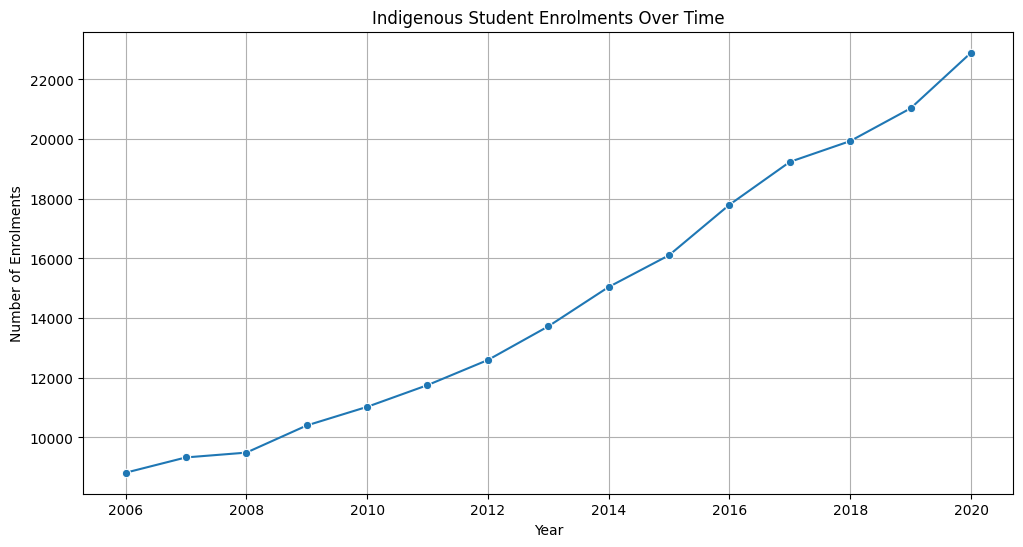

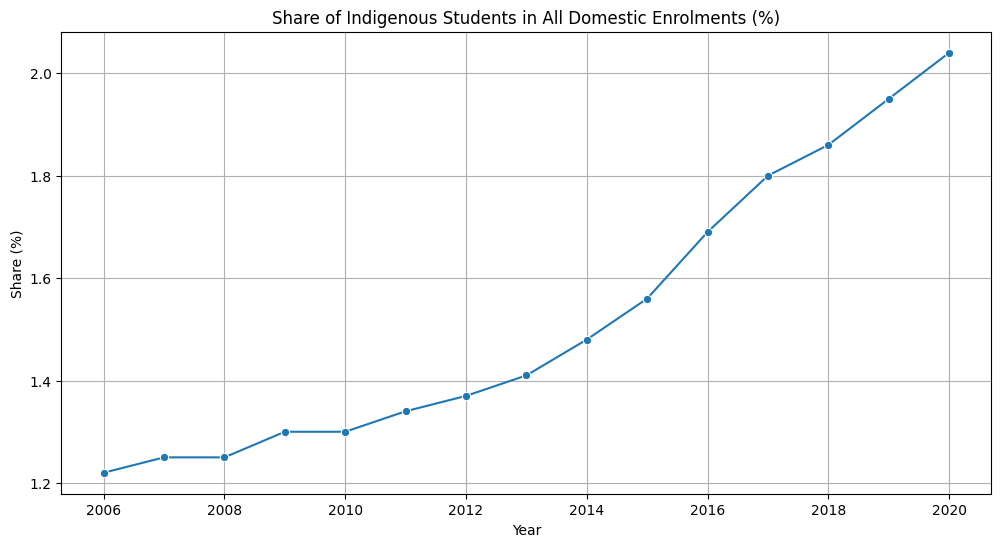

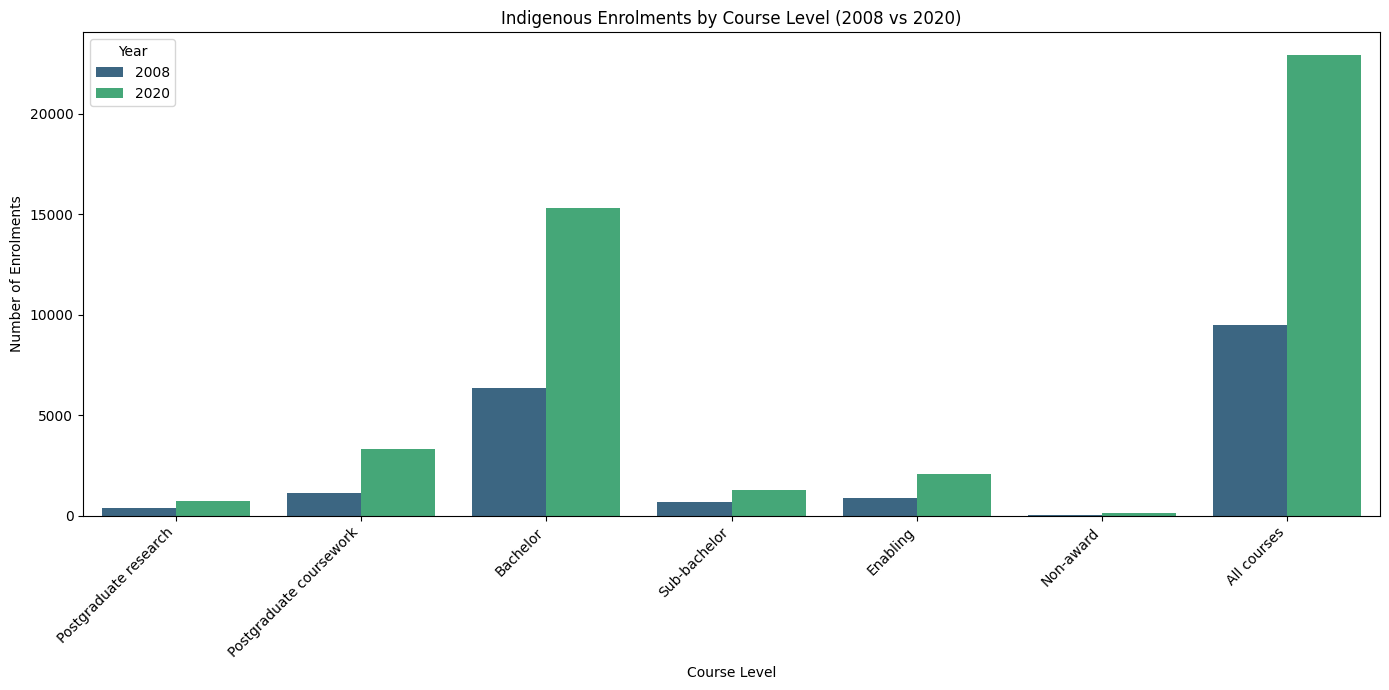

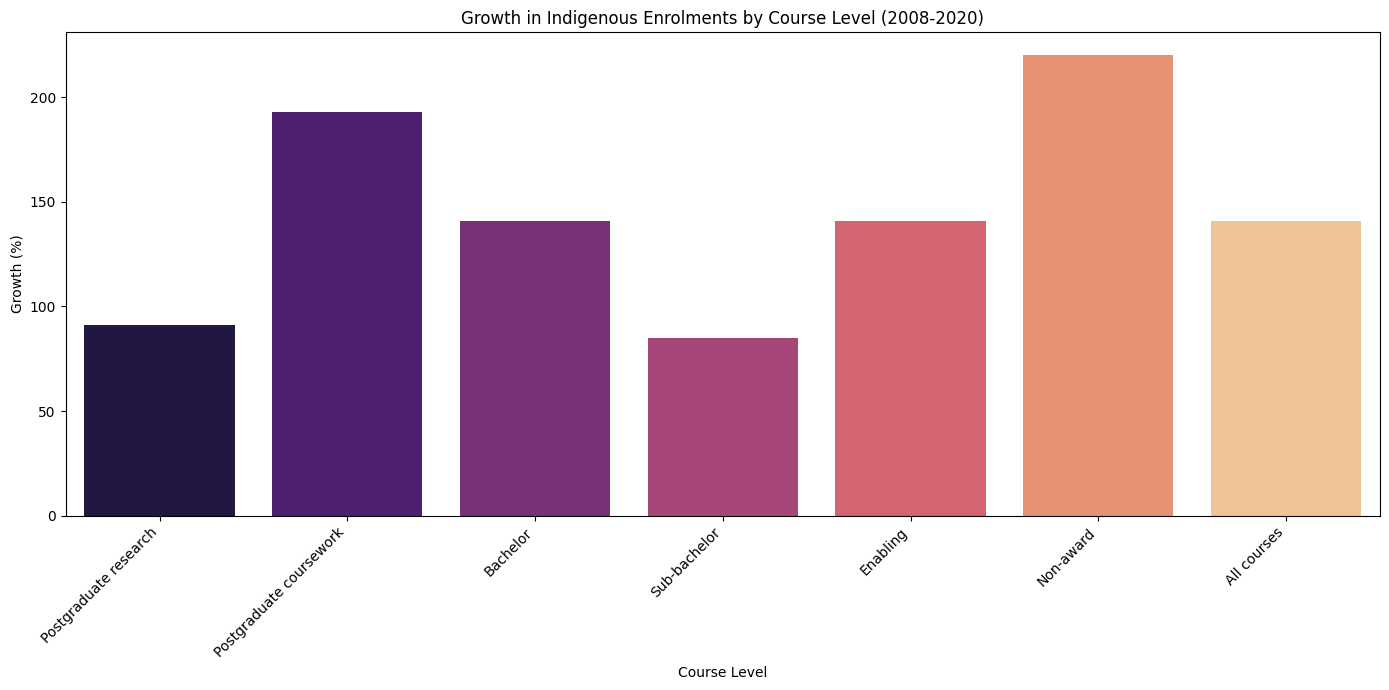

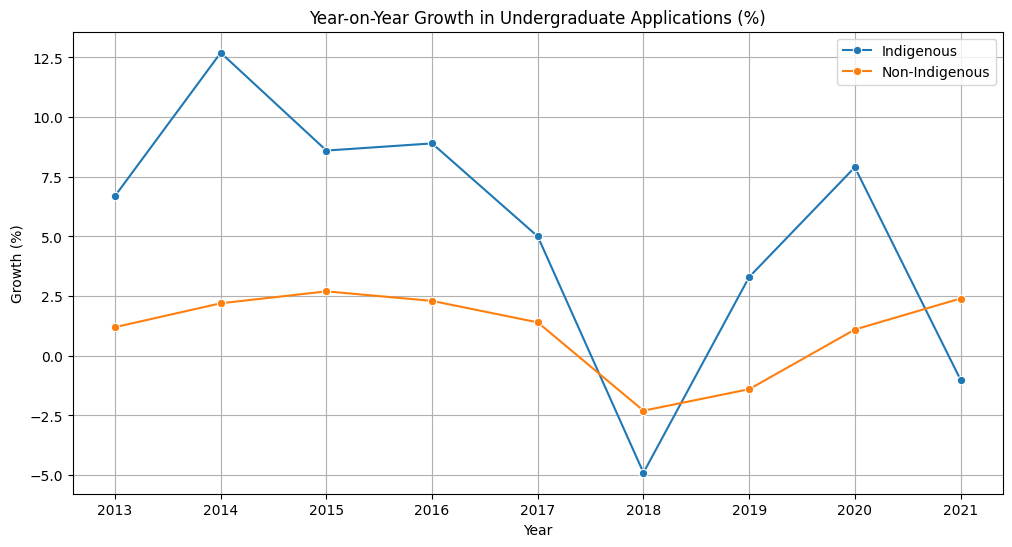

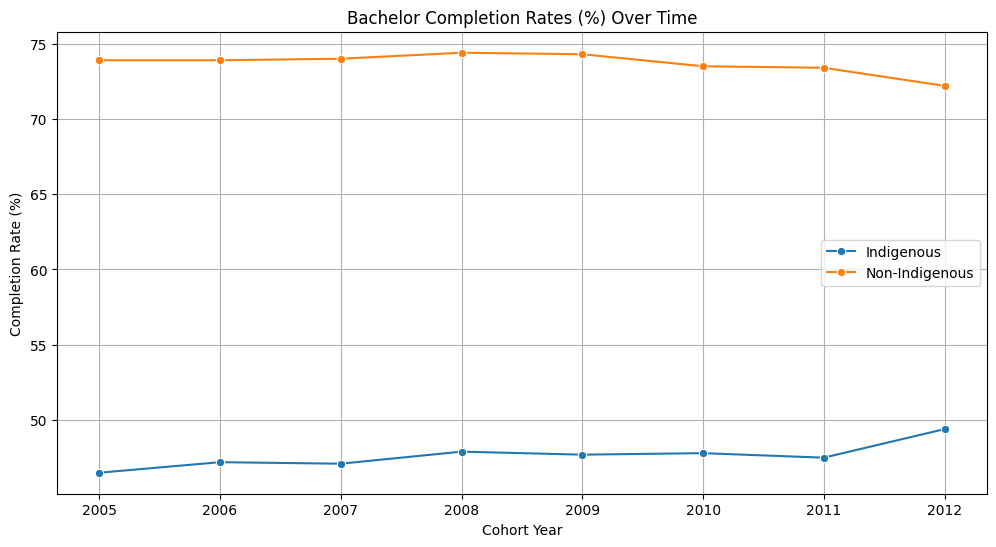

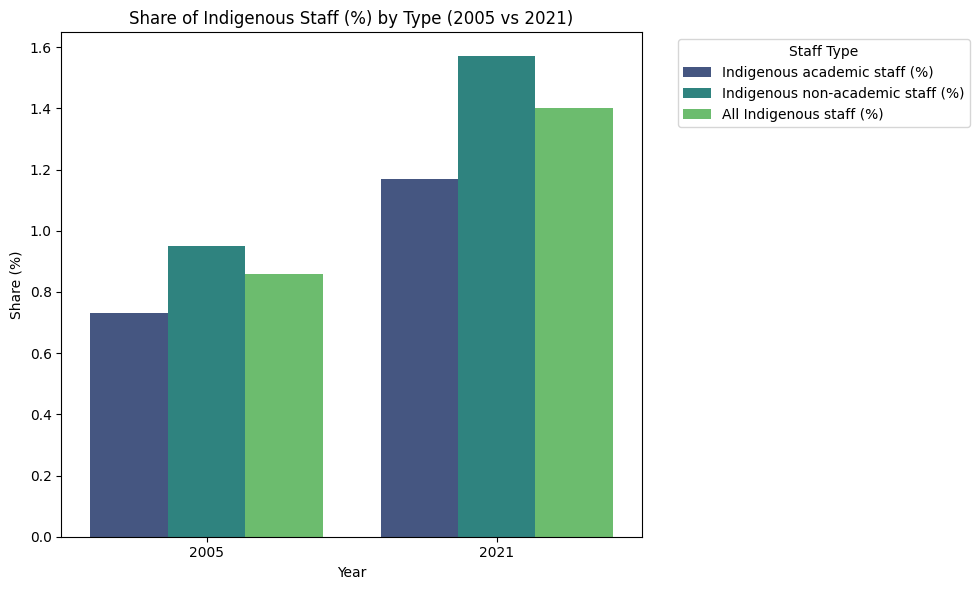

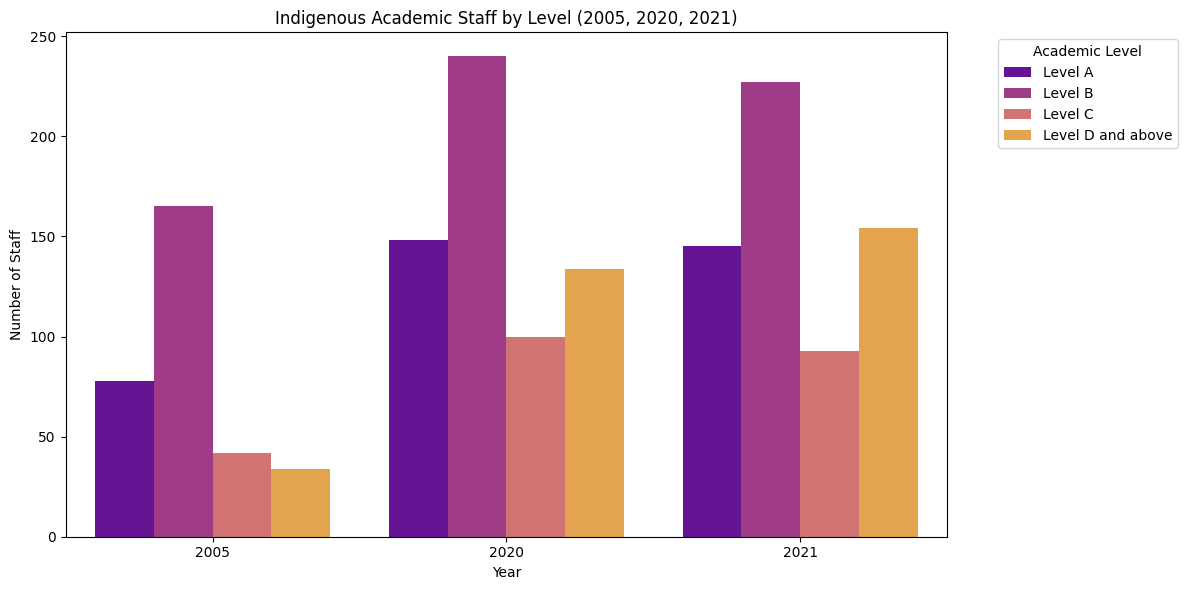

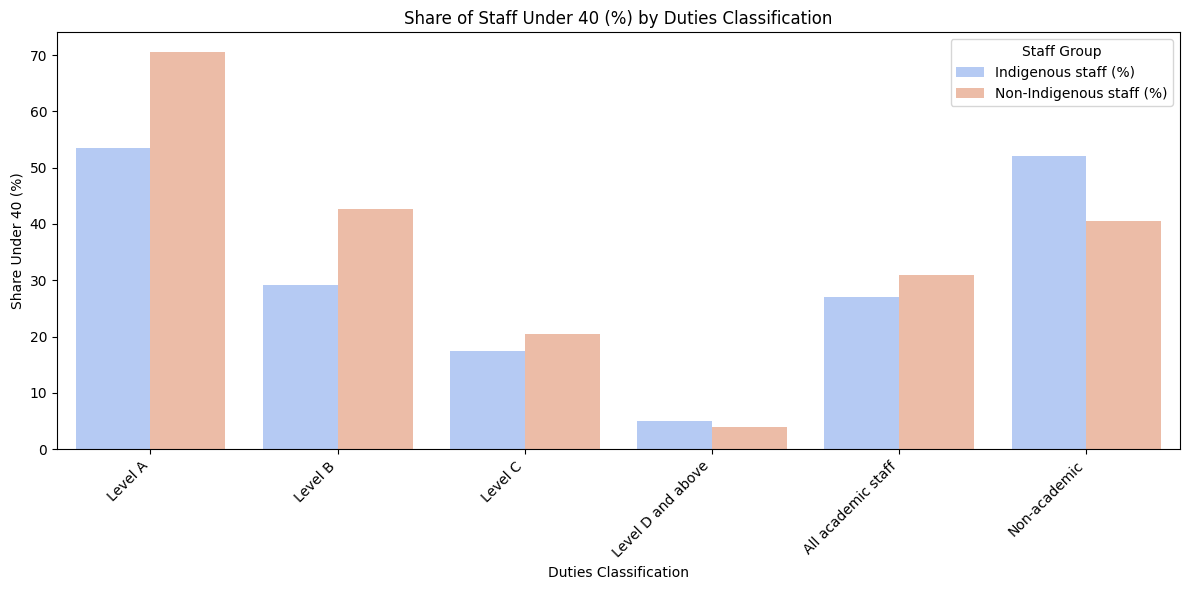

In [ ]:

# Assuming 'dataframes' dictionary contains the extracted dataframes

# Analyze Indigenous student enrolments over time
if 'indigenous_enrolments' in dataframes:
    enrolments_df = dataframes['indigenous_enrolments']

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=enrolments_df, x='Year', y='Indigenous student enrolments', marker='o')
    plt.title('Indigenous Student Enrolments Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Enrolments')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=enrolments_df, x='Year', y='Share of all domestic enrolments (%)', marker='o')
    plt.title('Share of Indigenous Students in All Domestic Enrolments (%)')
    plt.xlabel('Year')
    plt.ylabel('Share (%)')
    plt.grid(True)
    plt.show()
else:
    print("DataFrame 'indigenous_enrolments' not found.")


# 2. Analyze enrolments by course level
if 'enrolments_by_course_level' in dataframes:
    enrolments_level_df = dataframes['enrolments_by_course_level']

    # Melt the DataFrame for easier plotting of 2008 and 2020 data
    enrolments_level_melted = enrolments_level_df.melt(
        id_vars='Course level',
        value_vars=['2008', '2020'],
        var_name='Year',
        value_name='Number of Enrolments'
    )

    plt.figure(figsize=(14, 7))
    sns.barplot(data=enrolments_level_melted, x='Course level', y='Number of Enrolments', hue='Year', palette='viridis')
    plt.title('Indigenous Enrolments by Course Level (2008 vs 2020)')
    plt.xlabel('Course Level')
    plt.ylabel('Number of Enrolments')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Visualize Growth since 2008 (%)
    plt.figure(figsize=(14, 7))
    sns.barplot(data=enrolments_level_df, x='Course level', y='Growth since 2008 (%)', palette='magma')
    plt.title('Growth in Indigenous Enrolments by Course Level (2008-2020)')
    plt.xlabel('Course Level')
    plt.ylabel('Growth (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

else:
    print("DataFrame 'enrolments_by_course_level' not found.")

# 3. Analyze undergraduate applications growth over years
if 'undergrad_applications_growth' in dataframes:
    undergrad_applications_growth_df = dataframes['undergrad_applications_growth']
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=undergrad_applications_growth_df, x='Year', y='Indigenous (%)', marker='o', label='Indigenous')
    sns.lineplot(data=undergrad_applications_growth_df, x='Year', y='Non-Indigenous (%)', marker='o', label='Non-Indigenous')
    plt.title('Year-on-Year Growth in Undergraduate Applications (%)')
    plt.xlabel('Year')
    plt.ylabel('Growth (%)')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
     print("DataFrame 'undergrad_applications_growth' not found.")


# 4. Analyze bachelor completion rates comparison
if 'bachelor_completion_rates' in dataframes:
    bachelor_completion_rates_df = dataframes['bachelor_completion_rates']
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=bachelor_completion_rates_df, x='Cohort', y='Indigenous students (%)', marker='o', label='Indigenous')
    sns.lineplot(data=bachelor_completion_rates_df, x='Cohort', y='Non-Indigenous students (%)', marker='o', label='Non-Indigenous')
    plt.title('Bachelor Completion Rates (%) Over Time')
    plt.xlabel('Cohort Year')
    plt.ylabel('Completion Rate (%)')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("DataFrame 'bachelor_completion_rates' not found.")

# 5. Analyze staff data
if 'share_of_indigenous_staff' in dataframes:
    share_of_indigenous_staff_df = dataframes['share_of_indigenous_staff']
    share_of_indigenous_staff_melted = share_of_indigenous_staff_df.melt(
        id_vars='Year',
        value_vars=['Indigenous academic staff (%)', 'Indigenous non-academic staff (%)', 'All Indigenous staff (%)'],
        var_name='Staff Type',
        value_name='Share (%)'
    )
    plt.figure(figsize=(10, 6))
    sns.barplot(data=share_of_indigenous_staff_melted, x='Year', y='Share (%)', hue='Staff Type', palette='viridis')
    plt.title('Share of Indigenous Staff (%) by Type (2005 vs 2021)')
    plt.xlabel('Year')
    plt.ylabel('Share (%)')
    plt.legend(title='Staff Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'share_of_indigenous_staff' not found.")


if 'indigenous_staff_by_duties' in dataframes:
    indigenous_staff_by_duties_df = dataframes['indigenous_staff_by_duties']
    # Melt for plotting academic staff levels
    academic_staff_melted = indigenous_staff_by_duties_df.melt(
        id_vars='Year',
        value_vars=['Level A', 'Level B', 'Level C', 'Level D and above'],
        var_name='Academic Level',
        value_name='Number of Staff'
    )
    plt.figure(figsize=(12, 6))
    sns.barplot(data=academic_staff_melted, x='Year', y='Number of Staff', hue='Academic Level', palette='plasma')
    plt.title('Indigenous Academic Staff by Level (2005, 2020, 2021)')
    plt.xlabel('Year')
    plt.ylabel('Number of Staff')
    plt.legend(title='Academic Level', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'indigenous_staff_by_duties' not found.")


if 'staff_under_40' in dataframes:
    staff_under_40_df = dataframes['staff_under_40']
    staff_under_40_melted = staff_under_40_df.melt(
        id_vars='Duties classification',
        value_vars=['Indigenous staff (%)', 'Non-Indigenous staff (%)'],
        var_name='Staff Group',
        value_name='Share Under 40 (%)'
    )
    plt.figure(figsize=(12, 6))
    sns.barplot(data=staff_under_40_melted, x='Duties classification', y='Share Under 40 (%)', hue='Staff Group', palette='coolwarm')
    plt.title('Share of Staff Under 40 (%) by Duties Classification')
    plt.xlabel('Duties Classification')
    plt.ylabel('Share Under 40 (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'staff_under_40' not found.")

# Note: Analysis for 'undergrad_applications_disciplines' and 'postgrad_parity_figures'
# can be added here with appropriate checks if the dataframes exist.

Indigenous Enrolments: The number of Indigenous student enrolments and their share of all domestic enrolments has shown a steady increase from 2006 to 2020.

Course Level Enrolments: From 2008 to 2020, Indigenous enrolments saw significant growth across all course levels, with postgraduate coursework and sub-bachelor levels experiencing particularly high growth rates.

Undergraduate Applications: Year-on-year growth in Indigenous undergraduate applications has been more volatile compared to non-Indigenous applications, peaking in 2014 and 2020.

Completion Rates: There is a notable gap between the bachelor completion rates of Indigenous students (around 46-49%) and non-Indigenous students (around 73-74%).

Staff Data: The share of Indigenous academic, non-academic, and overall staff has increased from 2005 to 2021 . The distribution of Indigenous academic staff across different levels has also changed over time .

# Comprehensive Report on Business Review Analysis

## 1. Introduction
This report summarizes the analysis performed on the provided business review and metadata datasets using PySpark and pandas. The primary objectives were to understand the review data, analyze temporal patterns, build a recommendation system, and explore attributes of top-rated and lower-rated businesses.

## 2. Data Loading and Preparation
The analysis started by loading the `review.csv` and `meta-review-business.csv` datasets into Spark DataFrames. Initial data wrangling steps included:
- Handling missing values in the 'text' column by replacing them with 'no review'.
- Converting the 'time' column (Unix timestamp) to a standard date format ('yyyy-MM-dd') in a new column 'newtime'.
- Converting the 'time' column to extract the hour of the day in a new column 'review_time'.
- Creating a 'period_of_day' column based on the 'review_time'.
- Joining the review and meta-review dataframes on the 'gmap_id' column to combine review details with business metadata.

## 3. Data Analysis and Insights

### 3.1 Review Counts per Business
- The analysis of review counts per unique `gmap_id` showed that some businesses have a significantly higher number of reviews than others.
- Notably, a large number of reviews were associated with a null `gmap_id`, indicating potential data quality issues for some reviews.

### 3.2 Temporal Analysis of Reviews
- The distribution of review times revealed a curious pattern with peaks occurring during late night and early morning hours (12 am to 6 am) and lower activity around midday.
- This pattern was also observed when analyzing the distribution of reviews by defined periods of the day (0-6am, 6am-12pm, 12pm-6pm, 6pm-12am).
- Analyzing the hourly review patterns for the top 5 businesses by review count showed similar trough shapes with lower review activity around midday.
- The number of businesses reviewed in the morning time (6am-12pm) was found to be 6732.

### 3.3 Reviews by Day of the Week
- The distribution of reviews across the days of the week indicated that Sundays and Saturdays receive the highest number of reviews, while Fridays have the lowest count.

### 3.4 Top-Rated Businesses and Categories on Sunday
- Identifying businesses with the highest average ratings on Sundays revealed several categories with perfect or near-perfect average ratings, including Coffee shops, Gyms, and Gas Stations.
- Further exploration of the hourly distribution of reviews for these categories showed distinct patterns:
    - Gas stations and Coffee shops tend to have peaks at the extreme ends of the day (early morning and late evening/night) and dips towards midday.
    - Gyms showed a relatively flatter curve with fewer reviews overall and a more subtle dip around midday.

### 3.5 Word Frequency Analysis
- Analysis of the most common words in review text after removing stop words and punctuation provided insights into the general themes of reviews.
- The word clouds generated for different years showed variations in popular review words, reflecting potential shifts in customer experiences or focus over time. Sparseness was noted for early years like 1970 and 2007.

### 3.6 Unique Reviewers and Temporal Patterns
- Businesses with the most unique reviewers were identified (e.g., Walmart Supercenter, McDonald's), which could indicate higher customer acquisition or broader appeal.
- Categories with the most unique reviewers included various types of restaurants and retail stores, suggesting these are frequently reviewed business types.
- Temporal analysis of reviews across years, months, and days of the month showed:
    - A significant increase in the number of reviews starting around 2015, peaking in 2019, and then decreasing.
    - A peak in reviews during the seventh month (July), potentially correlating with holiday seasons.
    - A relatively uniform distribution of reviews across days of the month, with an expected dip on the 31st due to fewer months having this day.

### 3.7 Analysis of Ratings and Review Text

### 3.7.1 Average Ratings by Category
- Analyzing the average ratings per category revealed categories with the lowest average ratings, such as Electric utility companies, Debt collection agencies, and Police departments.
- A box plot of the distribution of ratings for the top 20 categories by review count showed that most ratings are above 3 out of 5, with some outliers.

### 3.7.2 Common Words in Lower-Rated Reviews
- Identifying the most common words in lower-rated reviews (e.g., ratings of 1 or 2) provided insights into common complaints or issues mentioned by dissatisfied customers. Words like "food", "service", "get", "place", and "time" were prominent.

### 3.8 User Review History

### 3.8.1 Business History per User
- The business history for each user was compiled, showing the sequence of businesses they reviewed, sorted by time.

### 3.8.2 Original and Distinct Business Counts
- Comparing the original number of reviews by a user to the count of distinct businesses reviewed showed that some users review the same business multiple times.

### 3.8.3 User Similarity based on Reviewed Businesses
- A strategy for calculating user similarity based on the set of businesses they have reviewed was outlined using Jaccard Similarity.
- An example calculation demonstrated that there could be very little overlap in the businesses reviewed by different users.

## 4. Recommendation System

### 4.1 ALS Algorithm Explanation
- The report includes an explanation of Spark's Alternating Least Squares (ALS) algorithm, highlighting its use in collaborative filtering for recommender systems, its matrix factorization approach, alternating steps, and key parameters.

### 4.2 ALS Model Building and Evaluation
- An ALS model was built using the review data, after preparing the data by indexing user and business IDs and casting ratings to a numeric type.
- The data was split into training and testing sets, and the model was trained on the training data.
- The model was evaluated using Root-Mean-Square Error (RMSE) on the test data, resulting in an RMSE of approximately 0.999.
- Top 10 business recommendations for each user and top 10 user recommendations for each business were generated.
- Recommendations for a specific sample user were successfully generated.
- Interpretation of ALS recommendations involves understanding that higher predicted ratings indicate stronger recommendations based on learned latent factors.

## 5. Time Series Analysis and Forecasting

### 5.1 Daily Review Volume Analysis
- The daily review volume was calculated and analyzed as a time series. Missing dates were filled with the mean number of reviews per day to create a continuous series.
- Time series decomposition (using an additive model with a period of 7 for weekly seasonality) revealed the trend, seasonality, and residual components of the daily review volume.
- Autocorrelation and Partial Autocorrelation plots were generated to understand the temporal dependencies in the data.

### 5.2 Time Series Forecasting with ARIMA
- A grid search was performed to find the optimal parameters (p, d, q) for an ARIMA model to forecast the daily review volume. The search considered parameter values from 0 to 2 for each component.
- The best ARIMA model found with the lowest Mean Absolute Error (MAE) was ARIMA(1, 0, 1), with an MAE of approximately 121.088.

### 5.3 Deep Learning Time Series Forecasting (Discussion)
- A discussion on using deep learning models like LSTM and RNNs for time series forecasting was included.
- Key data wrangling steps for deep learning models were outlined, including data cleaning, resampling to a uniform frequency, data normalization (e.g., MinMaxScaler), and creating sequences using a sliding window technique.
- Modeling steps involved defining the architecture (LSTM/GRU layers, Dense output layer), compiling the model (optimizer, loss function, metrics), training with epochs and batch size, and handling prediction/evaluation (including un-normalization and multi-step forecasting).

## 6. Analysis of PDF Data (Indigenous Education)

### 6.1 Data Extraction
- Data from several tables within the provided PDF report on Indigenous participation in Australian higher education was extracted and loaded into separate pandas DataFrames.

### 6.2 Data Analysis
- Analysis of the extracted data revealed several key insights:
    - Indigenous student enrolments and their share of domestic enrolments have steadily increased over time.
    - Significant growth in Indigenous enrolments was observed across all course levels between 2008 and 2020, particularly in postgraduate coursework and sub-bachelor levels.
    - Year-on-year growth in Indigenous undergraduate applications has been more variable compared to non-Indigenous applications.
    - A notable gap exists in bachelor completion rates between Indigenous and non-Indigenous students.
    - The share of Indigenous staff (academic and non-academic) has increased over time, with changes in the distribution of Indigenous academic staff across different levels.

## 7. Conclusion
This notebook successfully performed a comprehensive analysis of business reviews, built a recommendation system using ALS, explored temporal patterns and rating distributions, and extracted and analyzed data from a PDF report on Indigenous education. The findings provide valuable insights into customer behavior, business performance, potential areas for improvement, and trends in Indigenous participation in higher education. Further work could involve deploying the recommendation model, exploring more advanced time series forecasting techniques, and conducting deeper dives into specific aspects of the Indigenous education data.